# Statistical analysis of all subjects
Growth modeling, correlations, and other group-level analyses. Much of the code is adapted from Explore_Growth_Statistics.  Only single-ROI models are made in this notebook, and all three Pars regions are used (instead of 2, which was tested earlier).
** Includes creation of figures for the first F2F paper. **

In 2021 Dec, import of re-linearized ROI values was added.
In 2022 Jan, merging of Superior and Middle Temporal regions was added, then Transverse and Bank of Superior Temporal Sulcus. In 2022 Feb, the temporal merging was pared back to Superior and Middle along with the Temporal Pole.

In 2022 Jun, added scatter plots of attend-ignore contrast versus vocab score difference.

In 2023 Jun, adjusted font, font size, color ordering, and temporal ROI for final (?) manuscript push.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-1">Preliminaries</a></span></li><li><span><a href="#Load-and-transform-ROI-data" data-toc-modified-id="Load-and-transform-ROI-data-2">Load and transform ROI data</a></span></li><li><span><a href="#Load-and-transform-linearized-ROI-data" data-toc-modified-id="Load-and-transform-linearized-ROI-data-3">Load and transform linearized ROI data</a></span></li><li><span><a href="#Series-of-linear-models" data-toc-modified-id="Series-of-linear-models-4">Series of linear models</a></span><ul class="toc-item"><li><span><a href="#Baseline-linear-models" data-toc-modified-id="Baseline-linear-models-4.1">Baseline linear models</a></span></li><li><span><a href="#Models-(mdf2)-with-Inferior-Frontal-Gyrus-slope-covariants" data-toc-modified-id="Models-(mdf2)-with-Inferior-Frontal-Gyrus-slope-covariants-4.2">Models (mdf2) with Inferior Frontal Gyrus slope covariants</a></span></li><li><span><a href="#Models-(mdf3)-with-Inferior-Parietal-slope-covariants" data-toc-modified-id="Models-(mdf3)-with-Inferior-Parietal-slope-covariants-4.3">Models (mdf3) with Inferior Parietal slope covariants</a></span></li><li><span><a href="#Models-(mdf4)-with-Superior-Temporal-slope-covariants" data-toc-modified-id="Models-(mdf4)-with-Superior-Temporal-slope-covariants-4.4">Models (mdf4) with Superior Temporal slope covariants</a></span></li><li><span><a href="#Models-(mdf4b)-with-Combined-Temporal-slope-covariants" data-toc-modified-id="Models-(mdf4b)-with-Combined-Temporal-slope-covariants-4.5">Models (mdf4b) with Combined Temporal slope covariants</a></span></li><li><span><a href="#Models-(mdf5)-with-TWO-ROI-slope-covariants" data-toc-modified-id="Models-(mdf5)-with-TWO-ROI-slope-covariants-4.6">Models (mdf5) with TWO ROI slope covariants</a></span></li></ul></li><li><span><a href="#**FIG**-Graphically-represent-the-model-results" data-toc-modified-id="**FIG**-Graphically-represent-the-model-results-5">**FIG** Graphically represent the model results</a></span></li><li><span><a href="#**FIG**-Plot-RTP-versus-scores,-with-regression-lines" data-toc-modified-id="**FIG**-Plot-RTP-versus-scores,-with-regression-lines-6">**FIG** Plot RTP versus scores, with regression lines</a></span></li><li><span><a href="#**TEST**-Graphically-represent-the-model-results-(w/-linearized-ROI-instead-of-zscore)" data-toc-modified-id="**TEST**-Graphically-represent-the-model-results-(w/-linearized-ROI-instead-of-zscore)-7">**TEST** Graphically represent the model results (w/ linearized ROI instead of zscore)</a></span></li><li><span><a href="#**TEST**-Plot-scores-versus-RTP" data-toc-modified-id="**TEST**-Plot-scores-versus-RTP-8">**TEST** Plot scores versus RTP</a></span></li><li><span><a href="#**TEST**-Plot-RTP-contrasts-versus-scores" data-toc-modified-id="**TEST**-Plot-RTP-contrasts-versus-scores-9">**TEST** Plot RTP contrasts versus scores</a></span></li><li><span><a href="#**FIG**-Plot-labels-on-an-inflated-brain-map" data-toc-modified-id="**FIG**-Plot-labels-on-an-inflated-brain-map-10">**FIG** Plot labels on an inflated brain map</a></span></li><li><span><a href="#Plot-residuals-from-various-models" data-toc-modified-id="Plot-residuals-from-various-models-11">Plot residuals from various models</a></span></li><li><span><a href="#**FIG**-Plot-average-attend-and-ignore-levels-as-a-bar-graph---linear-validation" data-toc-modified-id="**FIG**-Plot-average-attend-and-ignore-levels-as-a-bar-graph---linear-validation-12">**FIG** Plot average attend and ignore levels as a bar graph - linear validation</a></span></li><li><span><a href="#End" data-toc-modified-id="End-13">End</a></span></li></ul></div>

## Preliminaries

In [79]:
%%capture

import os
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
from scipy.optimize import minimize_scalar
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import mne

%config InlineBackend.figure_format = 'png'
%matplotlib inline
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14})
plt.rcParams.update({'font.family':'sans-serif', 'font.sans-serif':['Arial']})
# adapted from stackoverflow.com/questions/21321670/how-to-change-fonts-in-matplotlib-python

mne.viz.set_3d_backend("pyvista")
pd.options.display.float_format = '{:,.5f}'.format

In [80]:
from matplotlib.font_manager import findfont, FontProperties
# font_used = findfont(FontProperties(family=['sans-serif']))
font_used = findfont(FontProperties(family=plt.rcParams['font.family']))
print(font_used)

/usr/share/fonts/truetype/msttcorefonts/Arial.ttf


In [81]:
# Define data space for loading and analysis #
# Originally this was done by loading a pre-derived .csv file (F2F_ROIBehav_2021Apr.xlsx',
# which was taken from "roi_ORIGINAL_THETA.csv" and "roi_extra_ORIGINAL_THETA.csv"
# in the "srcpsd_groups_2021Jan" results directory.).
score_file = './supporting_files/F2F_BehavOnly_2021Apr.xlsx'
score_columns = {'subject':'Subject', 'VOCAB_18m':'18', 'VOCAB_21m':'21', 
               'VOCAB_24m':'24', 'VOCAB_27m':'27', 'VOCAB_30m':'30'}

datadb_file = './results/srcpsd_groups_2022Jan/roi_REDUCED_THETA.csv'
datalin_file = './results/srcpsd_groups_2022Jan/roilinear_REDUCED_THETA.csv'
roi_abbrv = {'parstriangularis':'ParsTri', 'parsopercularis':'ParsOper',
             'parsorbitalis':'ParsOrb', 'inferiorparietal':'InfPar',
             'superiortemporal':'SupTemp', 'middletemporal':'MidTemp',
             'transversetemporal':'TransTemp', 'bankssts':'BanksTemp',
             'temporalpole': 'PoleTemp'
              }   # later add 'transversetemporal', 'bankssts'

months = np.arange(18,33, 3)
month_cols = [str(x) for x in months]

anatomy_dir = os.path.expanduser('~/Data/MEG/anatomy')
graphics_dir = './manuscript/graphics/'   # make sure the current directory is for this notebook!

In [82]:
# Define some ROI groupings #
runParams = {'pars_grouping':('ParsTri', 'ParsOper', 'ParsOrb'),
             'temporal_grouping':('SupTemp', 'MidTemp', 'PoleTemp')  # 'TransTemp', 'BanksTemp'
            }

In [83]:
# # Define some ROI groupings - TEST ONLY #
# runParams = {'pars_grouping':('ParsTri', 'ParsOper', 'ParsOrb'),
#              'temporal_grouping':('SupTemp',)
#             }

In [84]:
# Create a function for showing MSE, R-sq. (1 - MSE/var(scores)), and Bayesian Info. Crit. metrics #
# Note that the mean of the scores should be 0 (so below, scores_model.mean() < 2e-16),
# and because of the z-score tranformation, the sum of the scores _squared_ is 105 and the variance
# of the scores is 1.0.
def show_metrics(model_list):
    robj = re.compile('^month_t:Q\((.*)\)')
    r2_list, mse_list, bic_list, pval_list = [], [], [], []
    
    for model in model_list:  # m.resid := scores_model - m.fittedvalues
        r2 = 1 - ( sum(model.resid**2) / sum((scores_model - scores_model.mean())**2) )
        mse = sum(model.resid**2) / len(model.resid)
        r2_list.append(r2)
        mse_list.append(mse)
        bic_list.append(model.bic)  # bic := k * np.log(105) - 2 * model.llf (k=5 for 1 ROI, 6 for 2 ROI)
    
        fe_list = set(model.fe_params.index) - {'Intercept', 'month_t'}
        pval = None
        for param in fe_list:
            phit = robj.match(param)
            if phit:
                phit = phit.group(1).strip(r"'")
                pval = model.pvalues[param]
            pval_list.append(pval)

    print('R2: ', end='')
    for r2 in r2_list:
        print(r2, ' ', end='')
    print('\nMSE: ', end='')
    for mse in mse_list:
        print(mse, ' ', end='')
    print('\nBIC: ', end='')
    for bic in bic_list:
        print(bic, ' ', end='')
    print('\nPval: ', end='')
    for pval in pval_list:
        print(pval, ' ', end='')
    print()

## Load and transform ROI data
Note that the z-score transformation for the ROI scores will depend on the pool of labels pulled into the dataframe (matching USE_COLUMNS). So the values will be different for this version of the notebook (with more temporal lobe ROIs) than in previous versions (see _archived\_files_ folder).  

Note that the ROI data here is from Jan 2022 REDUCED set rather than Jan 2021 ORIGNAL set as in the previous notebook versions, though these two sets of values track very closely (within ~0.3 log units).  

In [85]:
# Expand the ROI abbreviations to ROI column names #
use_columns = {f'{roibase}-{hemi}-{cond1}':f'{cond2}_{colbase}-{hemi}' for
    (roibase, colbase) in roi_abbrv.items() for
    cond1, cond2 in zip(('talk', 'ignore'), ('attend', 'ignore')) for
    hemi in ('lh', 'rh')
    }

In [86]:
# Load in the vocab scores and ROI data #
df_scores = pd.read_excel(score_file, index_col=0, usecols=score_columns.keys())

df_roidb = pd.read_csv(datadb_file, index_col=0, header=0)
df_roidb = df_roidb[[key for key in use_columns]]

# Join the scores and data, then rename columns #
df_roidb = df_roidb.join(df_scores, how='right')
combine_columns = score_columns; combine_columns.update(use_columns)

order_list = list(combine_columns.keys())
order_list.pop(0)
df_roidb = df_roidb[order_list]
df_roidb.rename(columns=combine_columns, inplace=True);

In [88]:
# Standard arcsine transformation to deal with 0|100% saturating language scores #
# The ROI z-scores are slightly different than those obtained in the Explore_ notebook.
# Note that "np.array()" is necessary since June 2023 switch to newer conda and MNE stack. 
orig_scores = df_roidb.copy()[month_cols]

max_score = df_roidb[month_cols].max().max()
ya = np.arcsin(df_roidb[month_cols]/max_score * 0.97)
df_roidb[month_cols] = stats.zscore(np.array(ya), axis=None)   # update DF w/ transformed scores

df = df_roidb.copy()  # keep non-transformed ROI values unchanged
temp = df.iloc[:, 5:]
df.iloc[:, 5:] = stats.zscore(np.array(temp), axis=None)  # simpler transform for the ROI levels

df.head()

,18,21,24,27,30,attend_ParsTri-lh,attend_ParsTri-rh,ignore_ParsTri-lh,ignore_ParsTri-rh,attend_ParsOper-lh,attend_ParsOper-rh,ignore_ParsOper-lh,ignore_ParsOper-rh,attend_ParsOrb-lh,attend_ParsOrb-rh,ignore_ParsOrb-lh,ignore_ParsOrb-rh,attend_InfPar-lh,attend_InfPar-rh,ignore_InfPar-lh,ignore_InfPar-rh,attend_SupTemp-lh,attend_SupTemp-rh,ignore_SupTemp-lh,ignore_SupTemp-rh,attend_MidTemp-lh,attend_MidTemp-rh,ignore_MidTemp-lh,ignore_MidTemp-rh,attend_TransTemp-lh,attend_TransTemp-rh,ignore_TransTemp-lh,ignore_TransTemp-rh,attend_BanksTemp-lh,attend_BanksTemp-rh,ignore_BanksTemp-lh,ignore_BanksTemp-rh,attend_PoleTemp-lh,attend_PoleTemp-rh,ignore_PoleTemp-lh,ignore_PoleTemp-rh
subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f2f_009,-1.20258,-0.84281,-0.30567,0.59538,0.99481,0.04274,1.02224,-0.46355,0.08903,0.70741,1.14799,0.20788,0.24348,-0.34182,0.67883,-0.92861,-0.03508,0.58229,0.90861,-0.40781,-0.06931,0.35568,1.05691,-0.38491,0.34036,0.08309,0.89636,-0.55487,0.21732,0.57708,1.34408,0.05115,0.69358,0.62667,1.26729,-0.38849,0.40643,0.06108,0.85968,-0.29513,0.27690
f2f_010,-1.33074,-1.29473,-0.92429,-0.41760,0.18365,-2.56157,-1.02438,-1.51046,0.32705,-2.94051,-1.32984,-1.44769,0.19501,-1.95453,-0.81947,-1.42426,0.34961,-3.68550,-0.88759,-3.10786,-0.09687,-2.02400,-0.46551,-1.67712,0.33557,-2.08646,-0.83105,-1.52576,0.06262,-2.86213,-0.35547,-1.93928,0.43321,-2.81135,-0.87470,-2.59115,-0.03681,-2.02328,-1.46402,-1.25918,-0.15755
f2f_012,-1.08202,-0.98107,-0.58665,-0.00758,0.44438,0.14815,0.74592,0.30814,0.90209,-0.20589,1.47618,0.58182,0.60562,0.30319,0.59145,0.15312,0.89745,0.06141,0.34839,0.25024,1.08829,0.06661,0.83729,0.24237,0.57032,0.21034,0.42859,-0.14911,0.55638,0.24505,1.21552,0.14389,0.82279,0.11164,0.80292,0.01083,1.28234,0.80210,0.86838,0.08114,-0.45452
f2f_013,-1.09410,-0.63672,-0.03494,0.89220,1.72450,-1.40686,0.95020,1.22323,-0.82806,-2.11945,0.95536,0.97080,-0.87814,-0.35711,0.98936,1.23876,-0.68803,-0.44363,0.86847,0.42152,-2.55315,-1.35179,0.63137,1.01847,-2.00393,-0.69714,0.53829,0.91142,-2.69577,-1.19030,0.76581,0.99461,-1.72626,-1.09237,0.38994,0.65911,-2.79683,0.25707,0.96066,1.14195,-1.43861
f2f_018,-1.18252,0.15043,1.29829,2.28091,2.28091,1.92089,0.83451,-0.88199,-1.46315,1.82046,1.82392,-1.09481,-1.44422,1.72644,1.55221,-1.41957,-1.79294,-0.77097,1.63713,-1.64253,-1.88914,0.21539,1.96388,-1.17673,-2.21965,-0.14063,1.78734,-0.41173,-2.03407,0.57110,1.97763,-0.81267,-1.90401,-0.36665,1.62424,-1.05729,-2.36685,1.12908,2.04094,-0.48719,-1.20050


In [91]:
# Average the Pars and Temporal ROIs, by condition and hemisphere #
# Pars Triangularis region was left out in one version, but currently is kept for analysis.
avg_pars, avg_temp = {}, {}
for pre, post in zip(('attend', 'attend', 'ignore', 'ignore'),
                     ('lh', 'rh', 'lh', 'rh')):
    col_names = []
    for base in runParams['pars_grouping']:
        col_names.append(pre + '_' + base + '-' + post)
    avg = df[col_names].mean(axis=1)
    avg_name = pre + '_' + 'ParsAvg' + '-' + post
    avg_pars[avg_name] = avg
    
    col_names = []
    for base in runParams['temporal_grouping']:
        col_names.append(pre + '_' + base + '-' + post)
    avg = df[col_names].mean(axis=1)
    avg_name = pre + '_' + 'TempAvg' + '-' + post
    avg_temp[avg_name] = avg

# Add new columns to the existing data frame #
df_pars = pd.DataFrame(avg_pars)
df_temp = pd.DataFrame(avg_temp)
df = pd.concat([df, df_pars, df_temp], axis=1)

In [92]:
# Average the Pars ROIs for the non-zscore version, too #
avg_pars, avg_temp = {}, {}
for pre, post in zip(('attend', 'attend', 'ignore', 'ignore'),
                     ('lh', 'rh', 'lh', 'rh')):
    col_names = []
    for base in runParams['pars_grouping']:
        col_names.append(pre + '_' + base + '-' + post)
    avg = df_roidb[col_names].mean(axis=1)
    avg_name = pre + '_' + 'ParsAvg' + '-' + post
    avg_pars[avg_name] = avg
    
    col_names = []
    for base in runParams['temporal_grouping']:
        col_names.append(pre + '_' + base + '-' + post)
    avg = df_roidb[col_names].mean(axis=1)
    avg_name = pre + '_' + 'TempAvg' + '-' + post
    avg_temp[avg_name] = avg

# Add new columns to the existing data frame #
df_pars2 = pd.DataFrame(avg_pars)
df_temp2 = pd.DataFrame(avg_temp)
df_roidb = pd.concat([df_roidb, df_pars2, df_temp2], axis=1)

In [93]:
# Reconfigure dataframe for linear modeling so month becomes a variable #
df_time = df.copy().reset_index()
df_time = df_time.melt(id_vars = 'subject', value_vars=month_cols,
                       var_name='month', value_name='score')
df_time = df_time.astype({'month': 'int32'})

# Merge with static variables #
df_model = df_time.merge(df.iloc[:,5:], how='outer', left_on='subject', right_index=True)
df_model.reset_index(inplace=True, drop=True)

In [94]:
# Define a minimization function for transforming time #
def corr_expx_trim(df, p):
    '''Returns the corr. coef between vector y and e**(df['months']/p),
    averaged across all df['subject'].'''
    subject_list = df['subject'].unique()
    r_list = []
    for subject in subject_list:
        idx = df.index[df['subject'] == subject]
        x = df.loc[idx[:-1], 'month']  # don't include the last month
        y = df.loc[idx[:-1], 'score']
        r = np.corrcoef(np.exp(x/p), y)
        r_list.append(abs(r[0][1]))
    r_avg = stats.trim_mean(r_list, .1)
    return -r_avg

cost_function = partial(corr_expx_trim, df_model)

In [95]:
# Find the optimal exponent for transforming months #
# 11.88, skipping the last month. Or later 13.08.
min_result = minimize_scalar(cost_function, bounds=[.5, 400], method='bounded')
best_coef = min_result.x
print('\n', min_result)


  message: Solution found.
 success: True
  status: 0
     fun: -0.992064110722993
       x: 13.081749960655813
     nit: 18
    nfev: 18


In [96]:
# Add transformed months to the modeling data frame #
df_model.insert(2, 'month_t', np.exp(df_model['month']/best_coef))
df_model.head()

,subject,month,month_t,score,attend_ParsTri-lh,attend_ParsTri-rh,ignore_ParsTri-lh,ignore_ParsTri-rh,attend_ParsOper-lh,attend_ParsOper-rh,ignore_ParsOper-lh,ignore_ParsOper-rh,attend_ParsOrb-lh,attend_ParsOrb-rh,ignore_ParsOrb-lh,ignore_ParsOrb-rh,attend_InfPar-lh,attend_InfPar-rh,ignore_InfPar-lh,ignore_InfPar-rh,attend_SupTemp-lh,attend_SupTemp-rh,ignore_SupTemp-lh,ignore_SupTemp-rh,attend_MidTemp-lh,attend_MidTemp-rh,ignore_MidTemp-lh,ignore_MidTemp-rh,attend_TransTemp-lh,attend_TransTemp-rh,ignore_TransTemp-lh,ignore_TransTemp-rh,attend_BanksTemp-lh,attend_BanksTemp-rh,ignore_BanksTemp-lh,ignore_BanksTemp-rh,attend_PoleTemp-lh,attend_PoleTemp-rh,ignore_PoleTemp-lh,ignore_PoleTemp-rh,attend_ParsAvg-lh,attend_ParsAvg-rh,ignore_ParsAvg-lh,ignore_ParsAvg-rh,attend_TempAvg-lh,attend_TempAvg-rh,ignore_TempAvg-lh,ignore_TempAvg-rh
0,f2f_009,18,3.95889,-1.20258,0.04274,1.02224,-0.46355,0.08903,0.70741,1.14799,0.20788,0.24348,-0.34182,0.67883,-0.92861,-0.03508,0.58229,0.90861,-0.40781,-0.06931,0.35568,1.05691,-0.38491,0.34036,0.08309,0.89636,-0.55487,0.21732,0.57708,1.34408,0.05115,0.69358,0.62667,1.26729,-0.38849,0.40643,0.06108,0.85968,-0.29513,0.27690,0.13611,0.94969,-0.39476,0.09914,0.16662,0.93765,-0.41164,0.27819
1,f2f_009,21,4.97930,-0.84281,0.04274,1.02224,-0.46355,0.08903,0.70741,1.14799,0.20788,0.24348,-0.34182,0.67883,-0.92861,-0.03508,0.58229,0.90861,-0.40781,-0.06931,0.35568,1.05691,-0.38491,0.34036,0.08309,0.89636,-0.55487,0.21732,0.57708,1.34408,0.05115,0.69358,0.62667,1.26729,-0.38849,0.40643,0.06108,0.85968,-0.29513,0.27690,0.13611,0.94969,-0.39476,0.09914,0.16662,0.93765,-0.41164,0.27819
2,f2f_009,24,6.26273,-0.30567,0.04274,1.02224,-0.46355,0.08903,0.70741,1.14799,0.20788,0.24348,-0.34182,0.67883,-0.92861,-0.03508,0.58229,0.90861,-0.40781,-0.06931,0.35568,1.05691,-0.38491,0.34036,0.08309,0.89636,-0.55487,0.21732,0.57708,1.34408,0.05115,0.69358,0.62667,1.26729,-0.38849,0.40643,0.06108,0.85968,-0.29513,0.27690,0.13611,0.94969,-0.39476,0.09914,0.16662,0.93765,-0.41164,0.27819
3,f2f_009,27,7.87698,0.59538,0.04274,1.02224,-0.46355,0.08903,0.70741,1.14799,0.20788,0.24348,-0.34182,0.67883,-0.92861,-0.03508,0.58229,0.90861,-0.40781,-0.06931,0.35568,1.05691,-0.38491,0.34036,0.08309,0.89636,-0.55487,0.21732,0.57708,1.34408,0.05115,0.69358,0.62667,1.26729,-0.38849,0.40643,0.06108,0.85968,-0.29513,0.27690,0.13611,0.94969,-0.39476,0.09914,0.16662,0.93765,-0.41164,0.27819
4,f2f_009,30,9.90729,0.99481,0.04274,1.02224,-0.46355,0.08903,0.70741,1.14799,0.20788,0.24348,-0.34182,0.67883,-0.92861,-0.03508,0.58229,0.90861,-0.40781,-0.06931,0.35568,1.05691,-0.38491,0.34036,0.08309,0.89636,-0.55487,0.21732,0.57708,1.34408,0.05115,0.69358,0.62667,1.26729,-0.38849,0.40643,0.06108,0.85968,-0.29513,0.27690,0.13611,0.94969,-0.39476,0.09914,0.16662,0.93765,-0.41164,0.27819


## Load and transform linearized ROI data
Added 2021-12-14, to compare linear to original log values of the epoch-averaged ROI data. The linearized version is created to report statistics that match the bar chart in the section "\*FIG\* Plot attend and ignore levels", below.  

The dataframe _df\_roilin_ here is essentially analogous to _df\_roidb_ above. No modeling is performed with the linear version.

In [97]:
# Load in the ROI data #
df_roilin = pd.read_csv(datalin_file, index_col=0, header=0)
df_roilin = df_roilin[[key for key in use_columns]]

# Join the scores and data, then rename columns #
df_roilin = df_roilin.join(df_scores, how='right')
combine_columns = score_columns; combine_columns.update(use_columns)

order_list = list(combine_columns.keys())
order_list.pop(0)
df_roilin = df_roilin[order_list]
df_roilin.rename(columns=combine_columns, inplace=True);

In [98]:
# Standard arcsine transformation to deal with 0|100% saturating language scores #
max_score = df_roilin[month_cols].max().max()
ya = np.arcsin(df_roilin[month_cols]/max_score * 0.97)
df_roilin[month_cols] = stats.zscore(ya.values, axis=None)   # update dframe w/ transformed scores

In [99]:
# Average the Pars ROIs #
avg_pars, avg_temp = {}, {}
for pre, post in zip(('attend', 'attend', 'ignore', 'ignore'),
                     ('lh', 'rh', 'lh', 'rh')):
    col_names = []
    for base in runParams['pars_grouping']:
        col_names.append(pre + '_' + base + '-' + post)
    avg = df_roilin[col_names].mean(axis=1)
    avg_name = pre + '_' + 'ParsAvg' + '-' + post
    avg_pars[avg_name] = avg
    
    col_names = []
    for base in runParams['temporal_grouping']:
        col_names.append(pre + '_' + base + '-' + post)
    avg = df_roilin[col_names].mean(axis=1)
    avg_name = pre + '_' + 'TempAvg' + '-' + post
    avg_temp[avg_name] = avg

# Add new columns to the existing data frame #
df_pars2 = pd.DataFrame(avg_pars)
df_temp2 = pd.DataFrame(avg_temp)
df_roilin = pd.concat([df_roilin, df_pars2, df_temp2], axis=1)

df_roilin.head()

,18,21,24,27,30,attend_ParsTri-lh,attend_ParsTri-rh,ignore_ParsTri-lh,ignore_ParsTri-rh,attend_ParsOper-lh,attend_ParsOper-rh,ignore_ParsOper-lh,ignore_ParsOper-rh,attend_ParsOrb-lh,attend_ParsOrb-rh,ignore_ParsOrb-lh,ignore_ParsOrb-rh,attend_InfPar-lh,attend_InfPar-rh,ignore_InfPar-lh,ignore_InfPar-rh,attend_SupTemp-lh,attend_SupTemp-rh,ignore_SupTemp-lh,ignore_SupTemp-rh,attend_MidTemp-lh,attend_MidTemp-rh,ignore_MidTemp-lh,ignore_MidTemp-rh,attend_TransTemp-lh,attend_TransTemp-rh,ignore_TransTemp-lh,ignore_TransTemp-rh,attend_BanksTemp-lh,attend_BanksTemp-rh,ignore_BanksTemp-lh,ignore_BanksTemp-rh,attend_PoleTemp-lh,attend_PoleTemp-rh,ignore_PoleTemp-lh,ignore_PoleTemp-rh,attend_ParsAvg-lh,attend_ParsAvg-rh,ignore_ParsAvg-lh,ignore_ParsAvg-rh,attend_TempAvg-lh,attend_TempAvg-rh,ignore_TempAvg-lh,ignore_TempAvg-rh
subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f2f_009,-1.20258,-0.84281,-0.30567,0.59538,0.99481,43.37030,54.15661,38.66636,43.82789,50.42518,55.72306,45.02516,45.39004,39.74855,50.09948,34.79650,42.61166,49.01462,52.77906,39.15818,42.28220,46.55966,54.58409,39.36209,46.39820,43.76894,52.63263,37.87391,45.12160,48.95679,58.25663,43.45308,50.26728,49.51043,57.25103,39.33015,47.09860,43.55096,52.19667,40.17161,45.73534,44.51468,53.32638,39.49601,43.94320,44.62652,53.13780,39.13587,45.75171
f2f_010,-1.33074,-1.29473,-0.92429,-0.41760,0.18365,24.02841,34.04899,30.49554,46.25840,22.04996,31.77046,30.93266,44.89385,27.57434,35.66840,31.09742,46.49559,18.62267,35.12168,21.22889,42.01879,27.14334,38.64925,29.36454,46.34781,26.76163,35.57484,30.38990,43.56625,22.44533,39.62574,27.66984,47.38545,22.70526,35.22449,23.86779,42.59497,27.14778,30.81836,32.28354,41.44458,24.55090,33.82928,30.84188,45.88262,27.01759,35.01415,30.67933,43.78622
f2f_012,-1.08202,-0.98107,-0.58665,-0.00758,0.44438,44.41944,50.86747,46.06049,52.70099,40.99281,60.02810,49.00944,49.27465,46.00877,49.11661,44.46946,52.64565,43.55427,46.48281,45.45963,54.97386,43.60565,51.93230,45.37859,48.88175,45.05026,47.33585,41.52395,48.72750,45.40617,56.58291,44.37653,51.76183,44.05319,51.52916,43.05755,57.44676,51.51964,52.29969,43.74953,38.74564,43.80700,53.33739,46.51313,51.54043,46.72518,50.52261,43.55069,45.45163
f2f_013,-1.09410,-0.63672,-0.03494,0.89220,1.72450,31.22038,53.27914,56.68191,35.59895,26.56218,53.34155,53.52853,35.19701,39.61100,53.75435,56.88189,36.74750,38.84148,52.30082,47.26001,24.07432,31.61270,49.56321,54.11035,27.26717,36.67166,48.52809,52.81260,23.30824,32.79178,51.09743,53.81833,29.03919,33.52804,46.92273,49.87592,22.78015,45.53009,53.40561,55.64676,30.99644,32.46452,53.45834,55.69744,35.84782,37.93815,50.49897,54.18990,27.19061
f2f_018,-1.18252,0.15043,1.29829,2.28091,2.28091,66.39702,51.89962,35.16627,30.82444,64.90206,64.95302,33.50955,30.95703,63.53308,61.07193,31.13054,28.60342,36.06277,62.25940,29.59578,27.98619,45.10187,67.04746,32.89285,25.96551,41.60387,64.41654,39.12342,27.08147,48.89049,67.25683,35.72339,27.89204,39.52542,62.07761,33.79585,25.11311,55.48468,68.22932,38.45969,32.71602,64.94405,59.30819,33.26879,30.12830,47.39681,66.56444,36.82532,28.58766


## Series of linear models
Note that for the mixed models (Model 2+), R2 values can be calculated in different ways (e.g. the marginal and conditional r-squared values of Nakagawa + Shielzeth 2012). Regardless, here I've calculated it by hand using the traditional formula (1 - resid var./total var.).  
Also, models below are calculated _without_ the restricted ML method (which is otherwise on by default); mainly this is so a value for BIC can be obtained when .fit() is called.

### Baseline linear models

In [29]:
# MODEL 1 - Random intercept for each subject, no covariants; transformed time #
# As expected, log-likelihood and R2 value are better for transformed time.
md = smf.mixedlm("score ~ month_t", df_model, groups=df_model['subject'])
scores_model = md.data.endog    # actual scores, stored for later
mdf1 = md.fit(method='lbfgs', reml=False)
mdf1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: score   
No. Observations: 105     Method:             ML      
No. Groups:       21      Scale:              0.0742  
Min. group size:  5       Log-Likelihood:     -42.0208
Max. group size:  5       Converged:          Yes     
Mean group size:  5.0                                 
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept  -2.599    0.137 -18.983 0.000 -2.867 -2.331
month_t     0.394    0.013  31.296 0.000  0.369  0.419
Group Var   0.234    0.315                            
======================================================

"""

In [27]:
# MODEL 1n - Random intercept for each subject, no covariants; linear with time #
#
md = smf.mixedlm("score ~ month", df_model, groups=df_model['subject'])
mdf1_n = md.fit(method='lbfgs', reml=False)
mdf1_n.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: score   
No. Observations: 105     Method:             ML      
No. Groups:       21      Scale:              0.0781  
Min. group size:  5       Log-Likelihood:     -44.1806
Max. group size:  5       Converged:          Yes     
Mean group size:  5.0                                 
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept  -4.694    0.189 -24.865 0.000 -5.064 -4.324
month       0.196    0.006  30.433 0.000  0.183  0.208
Group Var   0.233    0.307                            
======================================================

"""

In [28]:
# R-square and BIC summary #
show_metrics((mdf1, mdf1_n))

R2: 0.9397855786773035  0.9365589499172551  
MSE: 0.060214421322696554  0.0634410500827449  
BIC: 102.65745604024308  106.97711884614604  
Pval: None  


### Models (mdf2) with Inferior Frontal Gyrus slope covariants
The average Broca's with only pars opercularis and orbitalis (column "ParsAvg2") gives slightly better results than with all three regions. That was used in the archived notebook, F2F_Growth_Statistics_Pars2Version. But here, all three are used.

In [38]:
# MODEL 2_lha - Left ParsAvg|attend predicting slope #
# Left is better than right and attend is better than ignore.
formula = "score ~ month_t + month_t:Q('attend_ParsAvg-lh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf2_lha = md.fit(method=['lbfgs'], reml=False)
mdf2_lha.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0688  
Min. group size:          5             Log-Likelihood:           -33.2442
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.115 -22.504 0.000 -2.825 -2.373
month_t                         0.388    0.012  31.832 0.000  0.364  0.412
month_t:Q('attend_ParsAvg-lh')  0.038    0.008   4.560 0.000  0.022  0.054
Group Var                       0.132    0.195                            
==========================================================================

"""

In [46]:
# MODEL 2_rha - Right ParsAvg|attend predicting slope #
formula = "score ~ month_t + month_t:Q('attend_ParsAvg-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf2_rha = md.fit(method=['lbfgs'], reml=False)
mdf2_rha.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0713  
Min. group size:          5             Log-Likelihood:           -36.2835
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.121 -21.452 0.000 -2.837 -2.362
month_t                         0.377    0.013  28.573 0.000  0.351  0.403
month_t:Q('attend_ParsAvg-rh')  0.045    0.013   3.589 0.000  0.021  0.070
Group Var                       0.155    0.222                            
==========================================================================

"""

In [48]:
# MODEL 2_lhi - Left ParsAvg|ignore predicting slope #
formula = "score ~ month_t + month_t:Q('ignore_ParsAvg-lh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf2_lhi = md.fit(method=['lbfgs'], reml=False)
mdf2_lhi.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0746  
Min. group size:          5             Log-Likelihood:           -41.6950
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.135 -19.276 0.000 -2.863 -2.335
month_t                         0.396    0.013  30.552 0.000  0.371  0.422
month_t:Q('ignore_ParsAvg-lh')  0.009    0.011   0.812 0.417 -0.013  0.031
Group Var                       0.221    0.303                            
==========================================================================

"""

In [49]:
# MODEL 2_rhi - Right ParsAvg|ignore predicting slope #
formula = "score ~ month_t + month_t:Q('ignore_ParsAvg-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf2_rhi = md.fit(method=['lbfgs'], reml=False)
mdf2_rhi.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0674  
Min. group size:          5             Log-Likelihood:           -38.2261
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.135 -19.182 0.000 -2.865 -2.334
month_t                         0.385    0.012  31.029 0.000  0.361  0.410
month_t:Q('ignore_ParsAvg-rh') -0.031    0.011  -2.774 0.006 -0.053 -0.009
Group Var                       0.240    0.344                            
==========================================================================

"""

In [61]:
# R-square and BIC summary #
show_metrics((mdf2_lha, mdf2_rha, mdf2_lhi, mdf2_rhi))

R2: 0.9436736790794188  0.9417982137730988  0.9394128193830761  0.9453487775984666  
MSE: 0.056326320920581256  0.05820178622690124  0.060587180616923884  0.05465122240153345  
BIC: 89.75822272326735  95.8367471726437  106.65971560736591  99.72197305265416  
Pval: 5.1212725883291135e-06  0.00033151216898320265  0.4166573529806247  0.005541010123795197  


### Models (mdf3) with Inferior Parietal slope covariants

In [62]:
# MODEL 3_lha - Left InfPar|attend predicting slope #
# Right is better than left and ignore is better than attend.
formula = "score ~ month_t + month_t:Q('attend_InfPar-lh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf3_lha = md.fit(method=['lbfgs'], reml=False)
mdf3_lha.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                   MixedLM       Dependent Variable:       score   
No. Observations:        105           Method:                   ML      
No. Groups:              21            Scale:                    0.0728  
Min. group size:         5             Log-Likelihood:           -39.9395
Max. group size:         5             Converged:                Yes     
Mean group size:         5.0                                             
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -2.599    0.131 -19.789 0.000 -2.857 -2.342
month_t                        0.398    0.013  31.512 0.000  0.373  0.423
month_t:Q('attend_InfPar-lh')  0.018    0.009   2.076 0.038  0.001  0.036
Group Var                      0.206    0.283                            
=========================================================================

"""

In [63]:
# MODEL 3_rha - Right InfPar|attend predicting slope #
formula = "score ~ month_t + month_t:Q('attend_InfPar-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf3_rha = md.fit(method=['lbfgs'], reml=False)
mdf3_rha.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                   MixedLM       Dependent Variable:       score   
No. Observations:        105           Method:                   ML      
No. Groups:              21            Scale:                    0.0649  
Min. group size:         5             Log-Likelihood:           -30.9799
Max. group size:         5             Converged:                Yes     
Mean group size:         5.0                                             
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -2.599    0.115 -22.699 0.000 -2.824 -2.375
month_t                        0.365    0.013  27.994 0.000  0.340  0.391
month_t:Q('attend_InfPar-rh')  0.079    0.016   5.106 0.000  0.049  0.110
Group Var                      0.136    0.202                            
=========================================================================

"""

In [64]:
# MODEL 3_lhi - Left InfPar|ignore predicting slope #
formula = "score ~ month_t + month_t:Q('ignore_InfPar-lh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf3_lhi = md.fit(method=['lbfgs'], reml=False)
mdf3_lhi.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                   MixedLM       Dependent Variable:       score   
No. Observations:        105           Method:                   ML      
No. Groups:              21            Scale:                    0.0741  
Min. group size:         5             Log-Likelihood:           -41.2366
Max. group size:         5             Converged:                Yes     
Mean group size:         5.0                                             
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -2.599    0.134 -19.420 0.000 -2.861 -2.337
month_t                        0.400    0.014  29.482 0.000  0.374  0.427
month_t:Q('ignore_InfPar-lh')  0.010    0.008   1.264 0.206 -0.006  0.026
Group Var                      0.217    0.296                            
=========================================================================

"""

In [65]:
# MODEL 3_rhi - Right InfPar|ignore predicting slope #
formula = "score ~ month_t + month_t:Q('ignore_InfPar-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf3_rhi = md.fit(method=['lbfgs'], reml=False)
mdf3_rhi.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                   MixedLM       Dependent Variable:       score   
No. Observations:        105           Method:                   ML      
No. Groups:              21            Scale:                    0.0689  
Min. group size:         5             Log-Likelihood:           -39.3356
Max. group size:         5             Converged:                Yes     
Mean group size:         5.0                                             
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -2.599    0.137 -19.002 0.000 -2.867 -2.331
month_t                        0.389    0.012  31.677 0.000  0.365  0.414
month_t:Q('ignore_InfPar-rh') -0.023    0.010  -2.324 0.020 -0.042 -0.004
Group Var                      0.244    0.346                            
=========================================================================

"""

In [66]:
# R-square and BIC summary #
show_metrics((mdf3_lha, mdf3_rha, mdf3_lhi, mdf3_rhi))

R2: 0.9408179363876492  0.9469847587034098  0.9397482548570304  0.9441230102544105  
MSE: 0.05918206361235079  0.05301524129659015  0.0602517451429696  0.055876989745589536  
BIC: 103.14879163157946  85.22966734569354  105.7429861181821  101.94090268247692  
Pval: 0.037880297313512994  3.2863425289838487e-07  0.20618287313665407  0.020133534047874668  


### Models (mdf4) with Superior Temporal slope covariants
Added for completeness, though likley not going to be in the paper. Not as predictive as for Inferior Parietal or Inferior Frontal (Avg. Pars).

In [67]:
# MODEL 4_lha - Left SupTemp|attend predicting slope #
# Right is better than left and _ignore_ is better than attend.
formula = "score ~ month_t + month_t:Q('attend_SupTemp-lh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf4_lha = md.fit(method=['lbfgs'], reml=False)
mdf4_lha.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0740  
Min. group size:          5             Log-Likelihood:           -39.7362
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.129 -20.225 0.000 -2.851 -2.347
month_t                         0.396    0.013  31.414 0.000  0.371  0.420
month_t:Q('attend_SupTemp-lh')  0.023    0.010   2.198 0.028  0.002  0.043
Group Var                       0.188    0.263                            
==========================================================================

"""

In [68]:
# MODEL 4_rha - Right SupTemp|attend predicting slope #
formula = "score ~ month_t + month_t:Q('attend_SupTemp-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf4_rha = md.fit(method=['lbfgs'], reml=False)
mdf4_rha.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0707  
Min. group size:          5             Log-Likelihood:           -36.6100
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.123 -21.129 0.000 -2.840 -2.358
month_t                         0.374    0.014  27.570 0.000  0.348  0.401
month_t:Q('attend_SupTemp-rh')  0.049    0.014   3.454 0.001  0.021  0.077
Group Var                       0.165    0.235                            
==========================================================================

"""

In [69]:
# MODEL 4_lhi - Left SupTemp|ignore predicting slope #
formula = "score ~ month_t + month_t:Q('ignore_SupTemp-lh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf4_lhi = md.fit(method=['lbfgs'], reml=False)
mdf4_lhi.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0743  
Min. group size:          5             Log-Likelihood:           -41.1879
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.133 -19.484 0.000 -2.861 -2.338
month_t                         0.399    0.013  30.488 0.000  0.373  0.424
month_t:Q('ignore_SupTemp-lh')  0.012    0.009   1.305 0.192 -0.006  0.031
Group Var                       0.214    0.293                            
==========================================================================

"""

In [70]:
# MODEL 4_rhi - Right SupTemp|ignore predicting slope #
formula = "score ~ month_t + month_t:Q('ignore_SupTemp-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf4_rhi = md.fit(method=['lbfgs'], reml=False)
mdf4_rhi.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0648  
Min. group size:          5             Log-Likelihood:           -36.1031
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.133 -19.603 0.000 -2.859 -2.339
month_t                         0.389    0.012  32.894 0.000  0.366  0.413
month_t:Q('ignore_SupTemp-rh') -0.038    0.011  -3.494 0.000 -0.060 -0.017
Group Var                       0.230    0.334                            
==========================================================================

"""

In [71]:
# R-square and BIC summary #
show_metrics((mdf4_lha, mdf4_rha, mdf4_lhi, mdf4_rhi))

R2: 0.9397473043666289  0.9422983434363081  0.939625039692499  0.9474426434054843  
MSE: 0.06025269563337113  0.05770165656369188  0.060374960307501016  0.05255735659451566  
BIC: 102.74213260829634  96.48976094509851  105.64555392578382  95.4759403386089  
Pval: 0.027952518967171696  0.0005522372382559007  0.19201826505749608  0.00047531273481204523  


### Models (mdf4b) with Combined Temporal slope covariants
Added 2022 Jan 5, then updated 2022 Jan 25 with more temporal regions.  Then updated again with a final (?) set of temporal regions. Results are similar to the Superior Temporal model.

In [72]:
# MODEL 4b_lha - Left TempAvg|attend predicting slope #
# Right is better than left and _ignore_ is better than attend.
formula = "score ~ month_t + month_t:Q('attend_TempAvg-lh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf4b_lha = md.fit(method=['lbfgs'], reml=False)
mdf4b_lha.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0733  
Min. group size:          5             Log-Likelihood:           -38.8234
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.126 -20.562 0.000 -2.847 -2.351
month_t                         0.391    0.013  31.042 0.000  0.366  0.415
month_t:Q('attend_TempAvg-lh')  0.029    0.011   2.621 0.009  0.007  0.050
Group Var                       0.178    0.250                            
==========================================================================

"""

In [73]:
# MODEL 4_rha - Right SupTemp|attend predicting slope #
formula = "score ~ month_t + month_t:Q('attend_TempAvg-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf4b_rha = md.fit(method=['lbfgs'], reml=False)
mdf4b_rha.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0682  
Min. group size:          5             Log-Likelihood:           -33.7987
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.118 -22.042 0.000 -2.830 -2.368
month_t                         0.373    0.013  28.623 0.000  0.347  0.398
month_t:Q('attend_TempAvg-rh')  0.055    0.013   4.351 0.000  0.030  0.080
Group Var                       0.145    0.211                            
==========================================================================

"""

In [74]:
# MODEL 4_lhi - Left SupTemp|ignore predicting slope #
formula = "score ~ month_t + month_t:Q('ignore_TempAvg-lh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf4b_lhi = md.fit(method=['lbfgs'], reml=False)
mdf4b_lhi.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0741  
Min. group size:          5             Log-Likelihood:           -40.9470
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.133 -19.586 0.000 -2.859 -2.339
month_t                         0.397    0.013  31.105 0.000  0.372  0.422
month_t:Q('ignore_TempAvg-lh')  0.015    0.010   1.485 0.138 -0.005  0.035
Group Var                       0.210    0.289                            
==========================================================================

"""

In [75]:
# MODEL 4_rhi - Right SupTemp|ignore predicting slope #
formula = "score ~ month_t + month_t:Q('ignore_TempAvg-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf4b_rhi = md.fit(method=['lbfgs'], reml=False)
mdf4b_rhi.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0678  
Min. group size:          5             Log-Likelihood:           -38.5010
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.136 -19.146 0.000 -2.865 -2.333
month_t                         0.389    0.012  31.884 0.000  0.365  0.413
month_t:Q('ignore_TempAvg-rh') -0.032    0.012  -2.669 0.008 -0.056 -0.009
Group Var                       0.241    0.344                            
==========================================================================

"""

In [76]:
# R-square and BIC summary #
show_metrics((mdf4b_lha, mdf4b_rha, mdf4b_lhi, mdf4b_rhi))

R2: 0.9402472944739343  0.9442406068763782  0.9397163072266883  0.9450238661981057  
MSE: 0.05975270552606574  0.05575939312362173  0.06028369277331173  0.05497613380189428  
BIC: 100.91655574442694  90.86727842405651  105.16374137458018  100.27183600169985  
Pval: 0.008754874456410967  1.3563295285733806e-05  0.1376212688325003  0.007607591265111703  


### Models (mdf5) with TWO ROI slope covariants
Added 2022 Feb 6. All variations of left-attend and right-ignore have positive and negative coefficients, respectively. Currently, the two being considered for the paper are mdf5_lharhiIFC and mdf5_lharhiMIX

In [52]:
# MODEL 5_lharhiIFC - IFC left attend and IFC right ignore! #
formula = "score ~ month_t + month_t:Q('attend_ParsAvg-lh') + month_t:Q('ignore_ParsAvg-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf5_lharhiIFC = md.fit(method=['lbfgs'], reml=False)
mdf5_lharhiIFC.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0623  
Min. group size:          5             Log-Likelihood:           -29.2158
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.113 -22.945 0.000 -2.821 -2.377
month_t                         0.380    0.012  31.876 0.000  0.357  0.404
month_t:Q('attend_ParsAvg-lh')  0.038    0.008   4.605 0.000  0.022  0.054
month_t:Q('ignore_ParsAvg-rh') -0.028    0.010  -2.824 0.005 -0.048 -0.009
Group Var                       0.135    0.214                            
==========================================================================

"""

In [53]:
# MODEL 5_lharhiIPC - IPC left attend and IPC right ignore! #
formula = "score ~ month_t + month_t:Q('attend_InfPar-lh') + month_t:Q('ignore_InfPar-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf5_lharhiIPC = md.fit(method=['lbfgs'], reml=False)
mdf5_lharhiIPC.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                   MixedLM       Dependent Variable:       score   
No. Observations:        105           Method:                   ML      
No. Groups:              21            Scale:                    0.0652  
Min. group size:         5             Log-Likelihood:           -35.3436
Max. group size:         5             Converged:                Yes     
Mean group size:         5.0                                             
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -2.599    0.129 -20.209 0.000 -2.851 -2.347
month_t                        0.394    0.012  32.680 0.000  0.370  0.418
month_t:Q('attend_InfPar-lh')  0.026    0.009   2.896 0.004  0.008  0.043
month_t:Q('ignore_InfPar-rh') -0.030    0.010  -3.056 0.002 -0.049 -0.011
Group Var                      0.207    0.304                            
=========================================================================

"""

In [54]:
# MODEL 5_lharhiIPC - IPC right attend and IPC right ignore! #\
# Going off script here, but IPC right attend was the "best" of the models above.
formula = "score ~ month_t + month_t:Q('attend_InfPar-rh') + month_t:Q('ignore_InfPar-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf5_rharhiIPC = md.fit(method=['lbfgs'], reml=False)
mdf5_rharhiIPC.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                   MixedLM       Dependent Variable:       score   
No. Observations:        105           Method:                   ML      
No. Groups:              21            Scale:                    0.0596  
Min. group size:         5             Log-Likelihood:           -27.8189
Max. group size:         5             Converged:                Yes     
Mean group size:         5.0                                             
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     -2.599    0.114 -22.880 0.000 -2.822 -2.376
month_t                        0.361    0.013  28.440 0.000  0.336  0.386
month_t:Q('attend_InfPar-rh')  0.080    0.015   5.204 0.000  0.050  0.110
month_t:Q('ignore_InfPar-rh') -0.021    0.009  -2.500 0.012 -0.038 -0.005
Group Var                      0.143    0.226                            
=========================================================================

"""

In [55]:
# MODEL 5_lharhiMIX - IFC left attend and IPC right ignore! #
formula = "score ~ month_t + month_t:Q('attend_ParsAvg-lh') + month_t:Q('ignore_InfPar-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf5_lharhiMIX = md.fit(method=['lbfgs'], reml=False)
mdf5_lharhiMIX.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0617  
Min. group size:          5             Log-Likelihood:           -28.5240
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.112 -23.181 0.000 -2.819 -2.379
month_t                         0.382    0.012  32.674 0.000  0.359  0.405
month_t:Q('attend_ParsAvg-lh')  0.041    0.008   5.094 0.000  0.026  0.057
month_t:Q('ignore_InfPar-rh')  -0.026    0.009  -3.070 0.002 -0.043 -0.009
Group Var                       0.131    0.208                            
==========================================================================

"""

In [56]:
# MODEL 5_lharhiMIX - IFC right ignore and IPC right attend! #
# A bit of a switch here, but going with the optimal single-ROI models.
formula = "score ~ month_t + month_t:Q('ignore_ParsAvg-rh') + month_t:Q('attend_InfPar-rh')"
md = smf.mixedlm(formula, df_model, groups=df_model['subject'])
mdf5_lharhiMIX = md.fit(method=['lbfgs'], reml=False)
mdf5_lharhiMIX.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       score   
No. Observations:         105           Method:                   ML      
No. Groups:               21            Scale:                    0.0568  
Min. group size:          5             Log-Likelihood:           -25.2096
Max. group size:          5             Converged:                Yes     
Mean group size:          5.0                                             
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                      -2.599    0.111 -23.508 0.000 -2.816 -2.382
month_t                         0.354    0.013  28.001 0.000  0.330  0.379
month_t:Q('ignore_ParsAvg-rh') -0.033    0.010  -3.406 0.001 -0.052 -0.014
month_t:Q('attend_InfPar-rh')   0.083    0.015   5.577 0.000  0.054  0.113
Group Var                       0.134    0.218                            
==========================================================================

"""

In [57]:
# R-square and BIC summary #
show_metrics((mdf5_lharhiIFC, mdf5_lharhiIPC, mdf5_rharhiIPC, mdf5_lharhiMIX, mdf5_lharhiMIX))

R2: 0.9491298509906176  0.9470277811847709  0.9514331655348984  0.9536645731572623  0.9536645731572623  
MSE: 0.05087014900938235  0.05297221881522908  0.04856683446510162  0.04633542684273774  0.04633542684273774  
BIC: 86.35526891931161  98.61094034308977  83.5614643952421  78.34293787708626  78.34293787708626  
Pval: 0.00473556619476042  4.125986157733898e-06  0.0037787180782876  0.002245503126266037  1.9489870901840987e-07  0.012413787934505887  0.0006598869072071736  2.4482535615552768e-08  0.0006598869072071736  2.4482535615552768e-08  


## \*\*FIG\*\* Graphically represent the model results
2021 Dec (and prior):  Using IPC left-attend model (mdf2_lha).
2022 Feb:  Using the 2-ROI model (mdf5_lharhiMIX).

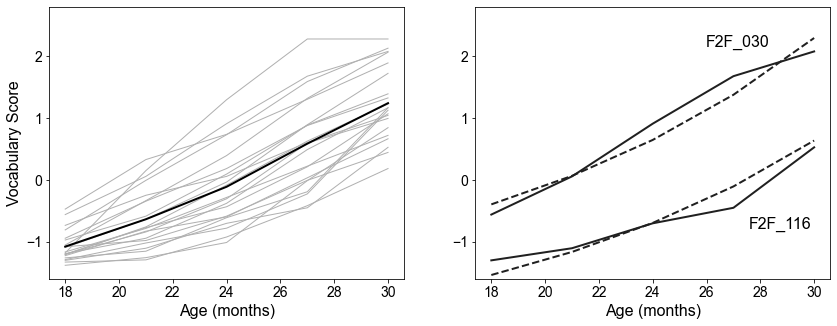

In [100]:
# Variant 3 from earlier notebook - June 2023: Only show overall mean now #
mdf_try = mdf5_lharhiMIX   # mdf2_lha

fig, axset = plt.subplots(1, 2, figsize=[14, 5])

for subject in df_model['subject'].unique():       # all subjects
    ridx = df_model['subject'] == subject
    x = df_model.loc[ridx, 'month']
    y_actual = df_model.loc[ridx, 'score']
    axset[0].plot(x, y_actual, color='#b0b0b0', linewidth=1);

cutoff = df['24'].median()
subjects_low = df.loc[df['24']<=cutoff].index
subjects_high = df.loc[df['24']>cutoff].index

# y_mean = df.loc[subjects_low, month_cols].mean()   # low subgroup
# axset[0].plot(x, y_mean, color='#00008B', linewidth=2);
# y_mean = df.loc[subjects_high, month_cols].mean()  # high subgroup
# axset[0].plot(x, y_mean, color='#A52A2A', linewidth=2);
y_mean = df.loc[:, month_cols].mean()    # all subjects combined subjects
axset[0].plot(x, y_mean, color='k', linewidth=2)

for subject in ('f2f_116', 'f2f_030'):             # specific subjects
    ridx = df_model['subject'] == subject
    x = df_model.loc[ridx, 'month']
    y_actual = df_model.loc[ridx, 'score']
    y_fitted = mdf_try.fittedvalues[ridx]
    
    axset[1].plot(x, y_actual, color='#202020', linewidth=2);
    axset[1].plot(x, y_fitted, color='#202020', linewidth=2, linestyle='--');

axset[1].text(0.77, 0.20, 'F2F_116', transform = axset[1].transAxes,
              horizontalalignment='left', verticalalignment='center');
axset[1].text(0.65, 0.87, 'F2F_030', transform = axset[1].transAxes,
              horizontalalignment='left', verticalalignment='center');
axset[0].set_ylabel('Vocabulary Score');
plt.setp(axset, xlabel='Age (months)', ylim=(-1.60, 2.80), yticks=[-1, 0, 1, 2]);

fig_name = os.path.join(graphics_dir, 'fitv_highlow.jpg')
fig.savefig(fig_name, dpi=500)

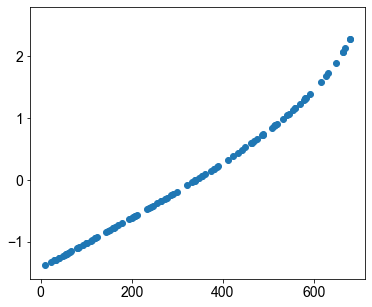

In [121]:
# For generating original vocab score numbers on the y-axis, plot transformed score versus original #
fig, ax = plt.subplots(1, 1, figsize=[6, 5])

yy = np.array(df_roidb[month_cols]).flatten()
xx = np.array(orig_scores)[:].flatten()

ax.plot(xx, yy, 'o');
plt.setp(ax, ylim=(-1.60, 2.80), yticks=[-1, 0, 1, 2])   # to match above

fig_name = os.path.join(graphics_dir, 'vocabscore_transformation.jpg')
fig.savefig(fig_name, dpi=500)

In [93]:
# Set up a function to determine per-subject/month estimated slopes #
# Note that the random effects was only used in a previous notebook.
def get_slope(subject, mdf):
    fe_list = set(mdf.fe_params.index) - {'Intercept', 'month_t'}
    for param in fe_list:
        assert(param[:].startswith('month_t'))  # make sure it's a slope parameter!
    
    b0, bx = mdf.fe_params["month_t"], 0
    if "month_t" in mdf.random_effects[subject].keys():
        bx = mdf.random_effects[subject]['month_t']
    
    ridx = df_model['subject'] == subject
    idx = np.where(ridx)[0][0]  # take first time pt (all same anyway)
    robj = re.compile('^month_t:Q\((.*)\)')
    
    slope = b0 + bx
    var = mdf.bse['month_t']**2
    for param in fe_list:
        col = robj.match(param).group(1).strip(r"'")
        slope += mdf.fe_params[param] * df_model.iloc[idx][col]
        var += \
            (mdf.bse[param] * df_model.iloc[idx][col])**2
    std = np.sqrt(var)
        
    return slope, std

In [94]:
# Like above, but only returns the ROI value #
def get_roival(subject, mdf):
    fe_list = set(mdf.fe_params.index) - {'Intercept', 'month_t'}
    for param in fe_list:
        assert(param[:].startswith('month_t'))  # make sure it's a slope parameter!
    fe_list = list(fe_list)
    
    if len(fe_list) > 1:
        raise ValueError('Only one ROI allowed')
    
    b0, bx = mdf.fe_params["month_t"], 0
    if "month_t" in mdf.random_effects[subject].keys():
        bx = mdf.random_effects[subject]['month_t']
    
    ridx = df_model['subject'] == subject
    idx = np.where(ridx)[0][0]  # take first time pt (all same anyway)
    robj = re.compile('^month_t:Q\((.*)\)')
    
    param = fe_list[0]
    col = robj.match(param).group(1).strip(r"'")
    val = df_model.iloc[idx][col]
        
    return val

In [95]:
# Like above, but less complicated by using the non-expanded (dB or linear) dataframe #
def get_roival2(subject, mdf, df_use=df_roidb):
    fe_list = set(mdf.fe_params.index) - {'Intercept', 'month_t'}
    for param in fe_list:
        assert(param[:].startswith('month_t'))  # make sure it's a slope parameter!
    fe_list = list(fe_list)
    
    if len(fe_list) > 1:
        raise ValueError('Only one ROI allowed')
    
    b0, bx = mdf.fe_params["month_t"], 0
    if "month_t" in mdf.random_effects[subject].keys():
        bx = mdf.random_effects[subject]['month_t']
    
    robj = re.compile('^month_t:Q\((.*)\)')    
    param = fe_list[0]
    col = robj.match(param).group(1).strip(r"'")
    
    val = df_use.loc[subject][col]
        
    return val

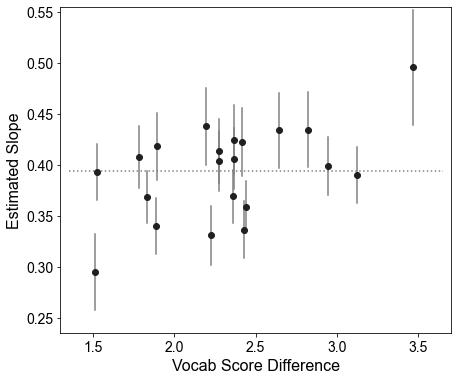

In [191]:
# All subjects' fitted slopes versus vocab differences, with 95% confidence intervals #
# Using the ParsAvg model (mdf2_lha) yields a similar result as the 2-ROI model (no longer made).
# MAKE SURE TO UNCOMMENT 'SAVEFIG()' LINE TO SAVE THE FIGURE!
mdf_try = mdf3_rha  # mdf2_lha, mdf3_rha

y1 = df_model.loc[df_model['month']==18, 'score'].values
y2 = df_model.loc[df_model['month']==30, 'score'].values

yfits, yconfs = [], []  # store slope est. AND confidence intvl (as abs. offset) for each subject
for subject in df_model['subject'].unique():
    slope, std = get_slope(subject, mdf_try)
    yfits.append(slope)
    yconfs.append(std * stats.norm.ppf(.025))

yhi = np.array(yfits) + np.array(yconfs)
ylo = np.array(yfits) - np.array(yconfs)
slope_control = mdf1.fe_params['month_t']
    
fig, ax = plt.subplots(1, 1, figsize=[7, 6]);
ax.plot(np.array([y2-y1, y2-y1]), np.array([ylo, yhi]), color='grey')
ax.plot([1.35, 3.65], [slope_control, slope_control], color='grey', linestyle=':')
ax.scatter(y2 - y1, yfits, marker='o', color='#202020', zorder=3);

plt.setp(ax, xlim=(1.30, 3.70), ylim=(0.235, 0.555), 
         xlabel='Vocab Score Difference',
         ylabel='Estimated Slope');

fig_name = os.path.join(graphics_dir, 'slope_vocabdiff_IPrh-attend.jpg')
fig.savefig(fig_name, dpi=500)

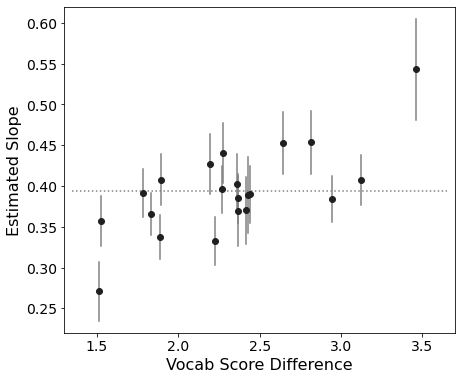

In [157]:
# All subjects' fitted slopes versus vocab differences, with 95% confidence intervals #
# Using the ParsAvg model (mdf2_lha) yields a similar result as the 2-ROI model (no longer made).
# MAKE SURE TO UNCOMMENT 'SAVEFIG()' LINE TO SAVE THE FIGURE!
mdf_try = mdf5_lharhiMIX  # mdf2_lha, mdf3_rha, mdf4_rhi, mdf3_rhi

y1 = df_model.loc[df_model['month']==18, 'score'].values
y2 = df_model.loc[df_model['month']==30, 'score'].values

yfits, yconfs = [], []  # store slope est. AND confidence intvl (as abs. offset) for each subject
for subject in df_model['subject'].unique():
    slope, std = get_slope(subject, mdf_try)
    yfits.append(slope)
    yconfs.append(std * stats.norm.ppf(.025))

yhi = np.array(yfits) + np.array(yconfs)
ylo = np.array(yfits) - np.array(yconfs)
slope_control = mdf1.fe_params['month_t']
    
fig, ax = plt.subplots(1, 1, figsize=[7, 6]);
ax.plot(np.array([y2-y1, y2-y1]), np.array([ylo, yhi]), color='grey')
ax.plot([1.35, 3.65], [slope_control, slope_control], color='grey', linestyle=':')
ax.scatter(y2 - y1, yfits, marker='o', color='#202020', zorder=3);

plt.setp(ax, xlim=(1.30, 3.7), ylim=(0.22, 0.62), 
         xlabel='Vocab Score Difference',
         ylabel='Estimated Slope');

# fig_name = os.path.join(graphics_dir, 'slope_vocabdiff_IPrh-attend.jpg')
# fig.savefig(fig_name, dpi=500)

## \*\*FIG\*\* Plot RTP versus scores, with regression lines
2022 Jun: Added IFC lh-ignore by request of PK.

r, p (pearsons): PearsonRResult(statistic=0.3050141623884981, pvalue=0.17879894169103303)
r, p (regression): (0.3050141623884982, 0.17879894169103264)
slope (regression): 0.46188259779599194




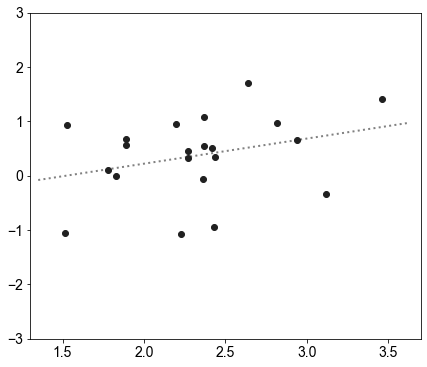

In [187]:
# All subjects' ROI value (theta level) versus vocab differences, with regression line #
# MAKE SURE TO UNCOMMENT 'SAVEFIG()' LINE TO SAVE THE FIGURE!
mdf_try = mdf2_rha  # 2023.06.05 for paper: mdf2_lha, lhi, rha, rhi, mdf3_rha, rhi
mdf_figname = 'roi_vocabdiff_IFCrh-attend.jpg'  # not allowed here: 2-ROI model

v1 = df_model.loc[df_model['month']==18, 'score'].values
v2 = df_model.loc[df_model['month']==30, 'score'].values

roivals = []  # unlike previous section, no confidence interval!
for subject in df_model['subject'].unique():
    roival = get_roival(subject, mdf_try)
    roivals.append(roival)

xmin, xmax = 1.35, 3.65
x = np.arange(xmin, xmax, 0.02)
r_pearsonr = stats.pearsonr(v2 - v1, roivals)       # also make regression line
r_linregress = stats.linregress(v2 - v1, roivals)   # identical
rline = r_linregress.intercept + r_linregress.slope * x
    
fig, ax = plt.subplots(1, 1, figsize=[7, 6]);
ax.plot(x, rline, color='grey', linestyle=':', linewidth=2)
ax.scatter(v2 - v1, roivals, marker='o', color='#202020', zorder=3);

plt.setp(ax, xlim=(xmin-0.05, xmax+0.05), ylim=(-3, 3))  # now leaving out labels for simplicity

fig_name = os.path.join(graphics_dir, mdf_figname)
fig.savefig(fig_name, dpi=500)

# Also report the correlation coefficient #
print(f'r, p (pearsons): {r_pearsonr}')
print(f'r, p (regression): {r_linregress.rvalue, r_linregress.pvalue}')
print(f'slope (regression): {r_linregress.slope}\n\n')

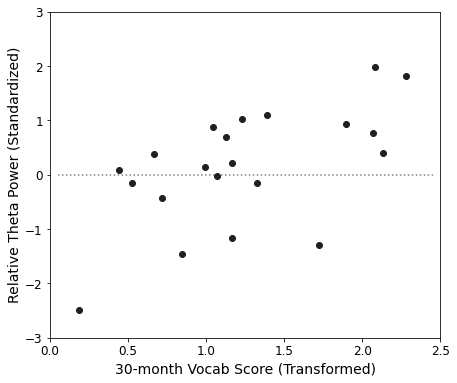

In [62]:
# Like above, but use only the 30-month vocabulary score instead of the difference #
# *TEST ONLY*
mdf_try = mdf2_lha  # 2022.01.27 for paper: mdf2_lha, mdf3_rhi; not in paper: mdf4b_rhi
mdf_figname = 'roi_vocab30_IFClh-attend.jpg'

y2 = df_model.loc[df_model['month']==30, 'score'].values

yfits = []  # unlike above, no confidence interval!
for subject in df_model['subject'].unique():
    roival = get_roival(subject, mdf_try)
    yfits.append(roival)
    
fig, ax = plt.subplots(1, 1, figsize=[7, 6]);
ax.plot([0.05, 2.45], [0, 0], color='grey', linestyle=':')  # 0 because ROI is z-score normed
ax.scatter(y2, yfits, marker='o', color='#202020', zorder=3);

plt.setp(ax, xlim=(0.00, 2.50), ylim=(-3, 3), 
         xlabel='30-month Vocab Score (Transformed)',
         ylabel='Relative Theta Power (Standardized)');

# fig_name = os.path.join(graphics_dir, mdf_figname)
# fig.savefig(fig_name, dpi=500)

## \*\*TEST\*\* Graphically represent the model results (w/ linearized ROI instead of zscore)
Weird, so not using. Could be linearizing from df_roidb would have been more similar to the above section, but moving on.

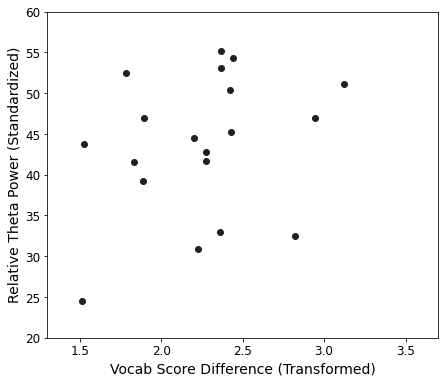

In [179]:
# All subjects' ROI value (theta level) versus vocab differences, with 95% confidence intervals #
# MAKE SURE TO UNCOMMENT 'SAVEFIG()' LINE TO SAVE THE FIGURE!
mdf_try = mdf2_lha  # 2022.01.27 for paper: mdf2_lha, mdf3_rhi; not in paper: mdf4b_rhi
mdf_figname = 'roi_vocabdiff_test-attend.jpg'

y1 = df_model.loc[df_model['month']==18, 'score'].values
y2 = df_model.loc[df_model['month']==30, 'score'].values

yfits = []  # unlike above, no confidence interval!
for subject in df_model['subject'].unique():
    roival = get_roival2(subject, mdf_try, df_roilin)
    yfits.append(roival)
    
fig, ax = plt.subplots(1, 1, figsize=[7, 6]);
ax.plot([1.35, 3.65], [0, 0], color='grey', linestyle=':')  # 0 because ROI is z-score normed
ax.scatter(y2 - y1, yfits, marker='o', color='#202020', zorder=3);

plt.setp(ax, xlim=(1.30, 3.70), ylim=(20, 60), 
         xlabel='Vocab Score Difference (Transformed)',
         ylabel='Relative Theta Power (Standardized)');

# fig_name = os.path.join(graphics_dir, mdf_figname)
# fig.savefig(fig_name, dpi=500)

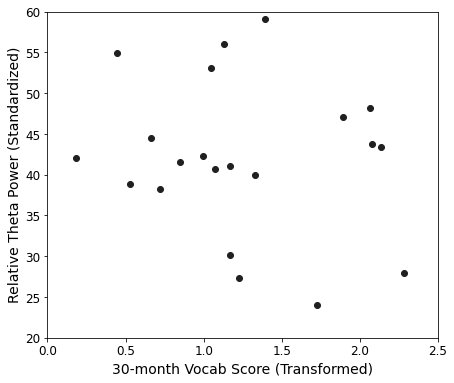

In [88]:
# Like above, but use only the 30-month vocabulary score instead of the difference #
mdf_try = mdf3_rhi  # 2022.01.27 for paper: mdf2_lha, mdf3_rhi; not in paper: mdf4b_rhi
mdf_figname = 'roi_vocab30_test-attend.jpg'

y2 = df_model.loc[df_model['month']==30, 'score'].values

yfits = []  # unlike above, no confidence interval!
for subject in df_model['subject'].unique():
    roival = get_roival2(subject, mdf_try, df_roilin)
    yfits.append(roival)
    
fig, ax = plt.subplots(1, 1, figsize=[7, 6]);
ax.plot([0.05, 2.45], [0, 0], color='grey', linestyle=':')  # 0 because ROI is z-score normed
ax.scatter(y2, yfits, marker='o', color='#202020', zorder=3);

plt.setp(ax, xlim=(0.00, 2.50), ylim=(20, 60), 
         xlabel='30-month Vocab Score (Transformed)',
         ylabel='Relative Theta Power (Standardized)');

# fig_name = os.path.join(graphics_dir, mdf_figname)
# fig.savefig(fig_name, dpi=500)

##  \*\*TEST\*\* Plot scores versus RTP
Note all the regions show relatively high activity for ignore vs attend. These plots aren't being used (they show similar info as the "roi" ones above.

In [321]:
# Define a plotting function #
def plot_growth(col, ax=None, color = '#353535', subject=None):
    '''Uses global dataframe 'df'.'''
    if subject:
        subject_list = [subject]
    else:
        subject_list = df.index
    for subject in subject_list:
        x = df.loc[subject, col]
        y1, y2 = df.loc[subject, low], df.loc[subject, high]
        ax.plot([x, x], [y1, y2], color=color)
        ax.plot(x, y1, marker='o', color=color, fillstyle='full', markerfacecolor='white')
        ax.plot(x, y2, marker='o', color=color, fillstyle='full')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Also define a labeling function #
def add_text(ax_array):
    ax_array[0, 0].text(0.02, 0.98, 'Attend, Left', transform = ax_array[0, 0].transAxes,
                 horizontalalignment='left', verticalalignment='center')
    ax_array[0, 1].text(0.02, 0.98, 'Attend, Right', transform = ax_array[0, 1].transAxes,
                 horizontalalignment='left', verticalalignment='center')
    ax_array[1, 0].text(0.02, 0.98, 'Ignore, Left', transform = ax_array[1, 0].transAxes,
             horizontalalignment='left', verticalalignment='center')
    ax_array[1, 1].text(0.02, 0.98, 'Ignore, Right', transform = ax_array[1, 1].transAxes,
         horizontalalignment='left', verticalalignment='center')

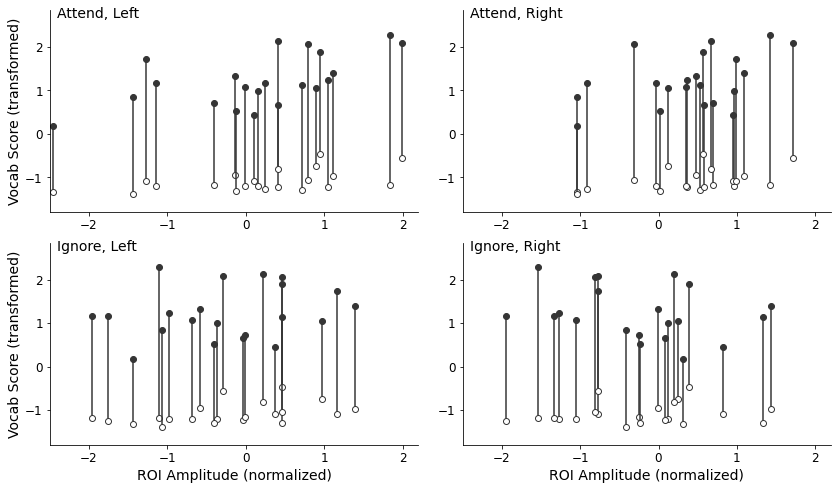

In [322]:
# Average Brocas: Plot 18- and 30-month scores (connected vertically) in order of ROI value #
# Pars Orbitalis by itself shows stronger attend-lh correlation.
low, high = '18', '30'
fig, axset = plt.subplots(2, 2, figsize = (14, 8))
fig.subplots_adjust(wspace=.12, hspace=.15)

plot_growth('attend_ParsAvg-lh', axset[0, 0])
plot_growth('attend_ParsAvg-rh', axset[0, 1])
plot_growth('ignore_ParsAvg-lh', axset[1, 0])
plot_growth('ignore_ParsAvg-rh', axset[1, 1])

plt.setp(axset, xlim=(-2.5, 2.2), ylim=(-1.8, 2.85));
plt.setp(axset[:, 0], ylabel='Vocab Score (transformed)');
plt.setp(axset[1, :], xlabel='ROI Amplitude (normalized)');
add_text(axset);

fig_name = os.path.join(graphics_dir, 'growth_ParsAvg.jpg')
fig.savefig(fig_name, dpi=500)

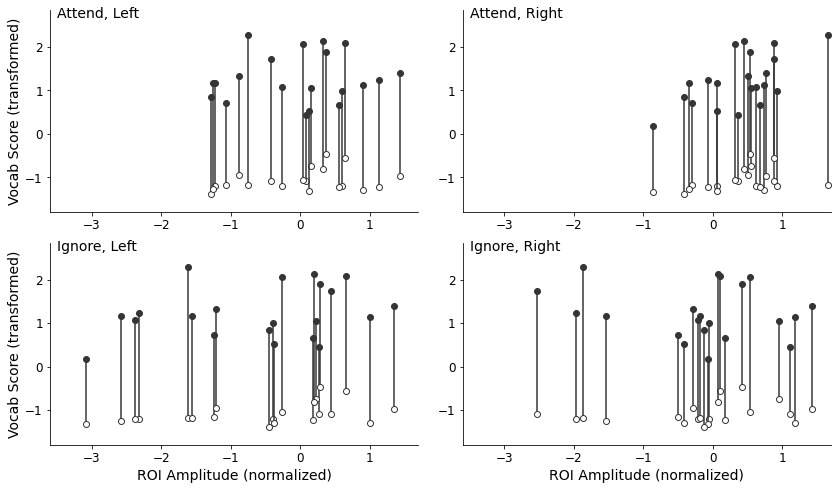

In [323]:
# Inferior Parietal: Similar to above, this time highlighting exemplary subjects #
# Quite the correlation for attend-rh, but activity relatively high here for all subjects!
low, high = '18', '30'
fig, axset = plt.subplots(2, 2, figsize = (14, 8))
fig.subplots_adjust(wspace=.12, hspace=.15)

plot_growth('attend_InfPar-lh', axset[0, 0])
plot_growth('attend_InfPar-rh', axset[0, 1])
plot_growth('ignore_InfPar-lh', axset[1, 0])
plot_growth('ignore_InfPar-rh', axset[1, 1])

# plot_growth('ignore_InfPar-rh', axset[0, 0], subject='f2f_116', color='#00008B')
# plot_growth('ignore_InfPar-rh', axset[0, 1], subject='f2f_116', color='#00008B')
# plot_growth('ignore_InfPar-rh', axset[1, 0], subject='f2f_116', color='#00008B')
# plot_growth('ignore_InfPar-rh', axset[1, 1], subject='f2f_116', color='#00008B')

# plot_growth('ignore_InfPar-rh', axset[0, 0], subject='f2f_030', color='#A52A2A')
# plot_growth('ignore_InfPar-rh', axset[0, 1], subject='f2f_030', color='#A52A2A')
# plot_growth('ignore_InfPar-rh', axset[1, 0], subject='f2f_030', color='#A52A2A')
# plot_growth('ignore_InfPar-rh', axset[1, 1], subject='f2f_030', color='#A52A2A')

plt.setp(axset, xlim=(-3.6, 1.7), ylim=(-1.8, 2.85));
plt.setp(axset[:, 0], ylabel='Vocab Score (transformed)');
plt.setp(axset[1, :], xlabel='ROI Amplitude (normalized)');
add_text(axset);

fig_name = os.path.join(graphics_dir, 'growth_InfPar.jpg')
fig.savefig(fig_name, dpi=500)

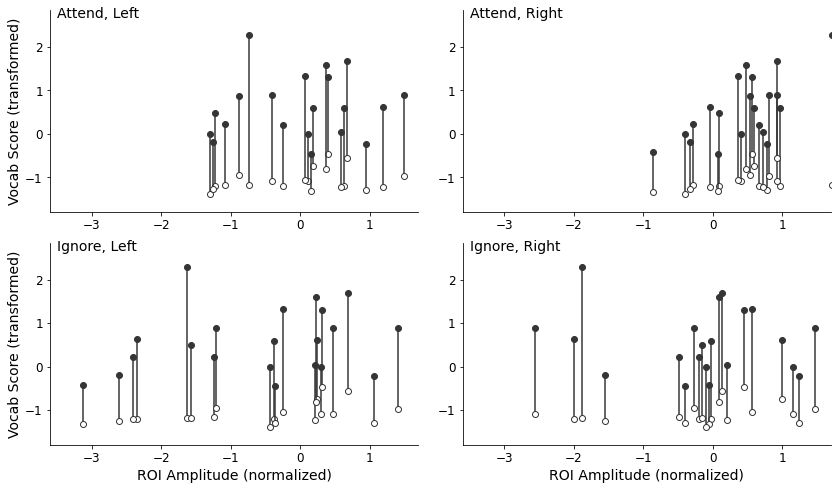

In [222]:
# Inferior Parietal: Similar to above, this with narrower month range #
# Quite the correlation for attend-rh, but activity relatively high here for all subjects!
low, high = '18', '27'
fig, axset = plt.subplots(2, 2, figsize = (14, 8))
fig.subplots_adjust(wspace=.12, hspace=.15)

plot_growth('attend_InfPar-lh', axset[0, 0])
plot_growth('attend_InfPar-rh', axset[0, 1])
plot_growth('ignore_InfPar-lh', axset[1, 0])
plot_growth('ignore_InfPar-rh', axset[1, 1])

# plot_growth('attend_InfPar-lh', axset[0, 0], subject='f2f_116', color='#00008B')
# plot_growth('attend_InfPar-rh', axset[0, 1], subject='f2f_116', color='#00008B')
# plot_growth('ignore_InfPar-lh', axset[1, 0], subject='f2f_116', color='#00008B')
# plot_growth('ignore_InfPar-rh', axset[1, 1], subject='f2f_116', color='#00008B')

# plot_growth('attend_InfPar-lh', axset[0, 0], subject='f2f_030', color='#A52A2A')
# plot_growth('attend_InfPar-rh', axset[0, 1], subject='f2f_030', color='#A52A2A')
# plot_growth('ignore_InfPar-lh', axset[1, 0], subject='f2f_030', color='#A52A2A')
# plot_growth('ignore_InfPar-rh', axset[1, 1], subject='f2f_030', color='#A52A2A')

plt.setp(axset, xlim=(-3.6, 1.7), ylim=(-1.8, 2.85));
plt.setp(axset[:, 0], ylabel='Vocab Score (transformed)');
plt.setp(axset[1, :], xlabel='ROI Amplitude (normalized)');
add_text(axset);

fig_name = os.path.join(graphics_dir, 'growth_InfPar_18to27.jpg')
fig.savefig(fig_name, dpi=500)

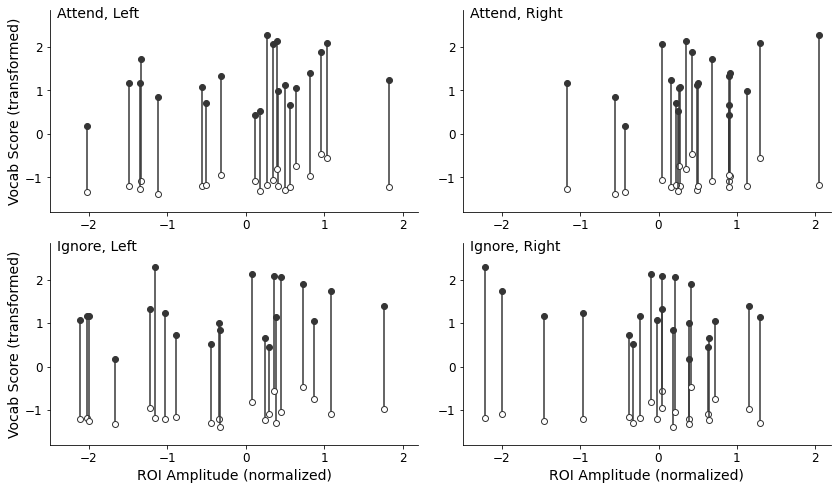

In [223]:
# Superior Temporal: Similar to above #
# No discernable patterns.
low, high = '18', '30'
fig, axset = plt.subplots(2, 2, figsize = (14, 8))
fig.subplots_adjust(wspace=.12, hspace=.15)

plot_growth('attend_SupTemp-lh', axset[0, 0])
plot_growth('attend_SupTemp-rh', axset[0, 1])
plot_growth('ignore_SupTemp-lh', axset[1, 0])
plot_growth('ignore_SupTemp-rh', axset[1, 1])

plt.setp(axset, xlim=(-2.5, 2.2), ylim=(-1.8, 2.85));
plt.setp(axset[:, 0], ylabel='Vocab Score (transformed)');
plt.setp(axset[1, :], xlabel='ROI Amplitude (normalized)');
add_text(axset);

fig_name = os.path.join(graphics_dir, 'growth_SupTemp.jpg')
fig.savefig(fig_name, dpi=500)

##  \*\*TEST\*\* Plot RTP contrasts versus scores
At request from PK, these plots are sort of the inverse of the above sets, and without the lines.

In [46]:
# Define a plotting function #
def plot_contrast(col_partial, ax=None, color = '#353535', subject=None):
    '''Uses global dataframe 'df'.'''
    if subject:
        subject_list = [subject]
    else:
        subject_list = df.index
    for subject in subject_list:
        x = df.loc[subject, high] - df.loc[subject, low]
        y1 = df.loc[subject, 'ignore_' + col_partial]
        y2 = df.loc[subject, 'attend_' + col_partial]
        ax.plot(x, y2 - y1, marker='o', color=color, fillstyle='full')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Also define a labeling function #
def add_text2(ax_array, roi_str):
    ax_array[0].text(0.02, 0.98, roi_str + ', left',
                     transform = ax_array[0].transAxes,
                     horizontalalignment='left', verticalalignment='center')
    ax_array[1].text(0.02, 0.98, roi_str + ', right',
                     transform = ax_array[1].transAxes,
                     horizontalalignment='left', verticalalignment='center')

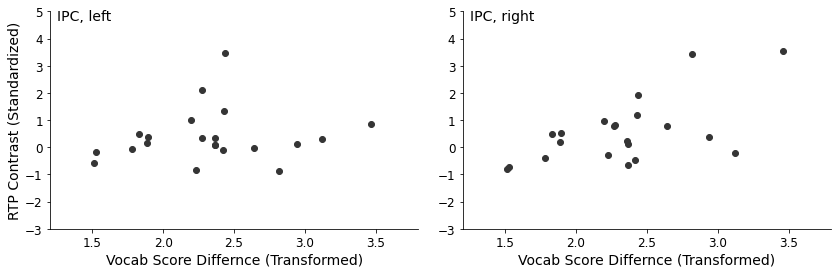

In [54]:
# Inferior Parietal: Right hemisphere shows high correlation.
low, high = '18', '30'
fig, axset = plt.subplots(1, 2, figsize = (14, 4))
fig.subplots_adjust(wspace=.12, hspace=.15)

plot_contrast('InfPar-lh', axset[0])
plot_contrast('InfPar-rh', axset[1])

plt.setp(axset, xlim=(1.2, 3.8), ylim=(-3.0, 5.0));
plt.setp(axset[0], ylabel='RTP Contrast (Standardized)');
plt.setp(axset[:], xlabel='Vocab Score Difference (Transformed)');
add_text2(axset, 'IPC');

fig_name = os.path.join(graphics_dir, 'contrast_vocabdiff_IPC.jpg')
fig.savefig(fig_name, dpi=500)

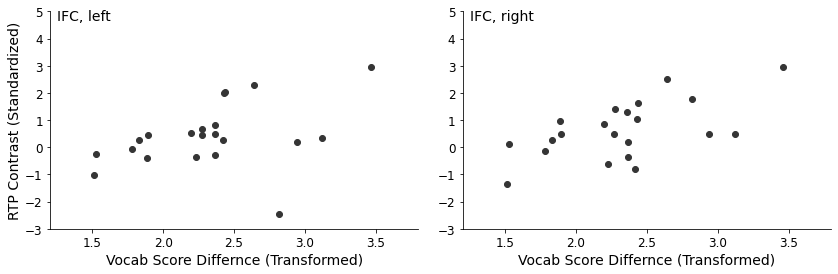

In [53]:
# Inferior Frontal: Right hemisphere shows correlation, but not as much as IPC right.
low, high = '18', '30'
fig, axset = plt.subplots(1, 2, figsize = (14, 4))
fig.subplots_adjust(wspace=.12, hspace=.15)

plot_contrast('ParsAvg-lh', axset[0])
plot_contrast('ParsAvg-rh', axset[1])

plt.setp(axset, xlim=(1.2, 3.8), ylim=(-3.0, 5.0));
plt.setp(axset[0], ylabel='RTP Contrast (Standardized)');
plt.setp(axset[:], xlabel='Vocab Score Differnce (Transformed)');
add_text2(axset, 'IFC');

fig_name = os.path.join(graphics_dir, 'contrast_vocabdiff_IFC.jpg')
fig.savefig(fig_name, dpi=500)

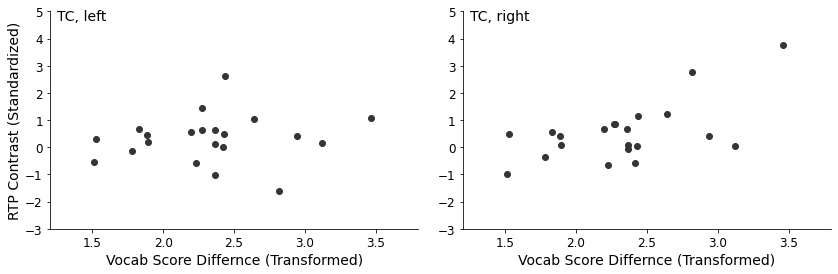

In [52]:
# Temporal: Right hemisphere shows correlation, but not as much as IPC right.
low, high = '18', '30'
fig, axset = plt.subplots(1, 2, figsize = (14, 4))
fig.subplots_adjust(wspace=.12, hspace=.15)

plot_contrast('TempAvg-lh', axset[0])
plot_contrast('TempAvg-rh', axset[1])

plt.setp(axset, xlim=(1.2, 3.8), ylim=(-3.0, 5.0));
plt.setp(axset[0], ylabel='RTP Contrast (Standardized)');
plt.setp(axset[:], xlabel='Vocab Score Differnce (Transformed)');
add_text2(axset, 'TC');

fig_name = os.path.join(graphics_dir, 'contrast_vocabdiff_TC.jpg')
fig.savefig(fig_name, dpi=500)

In [44]:
# Define a plotting function #
def plot_contrastVattend(col_partial, ax=None, color = '#353535', subject=None):
    '''Uses global dataframe 'df'.'''
    if subject:
        subject_list = [subject]
    else:
        subject_list = df.index
    for subject in subject_list:
#         x = df.loc[subject, high] - df.loc[subject, low]
        y1 = df.loc[subject, 'ignore_' + col_partial]
        y2 = df.loc[subject, 'attend_' + col_partial]
        ax.plot(y2, y2 - y1, marker='o', color=color, fillstyle='full')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

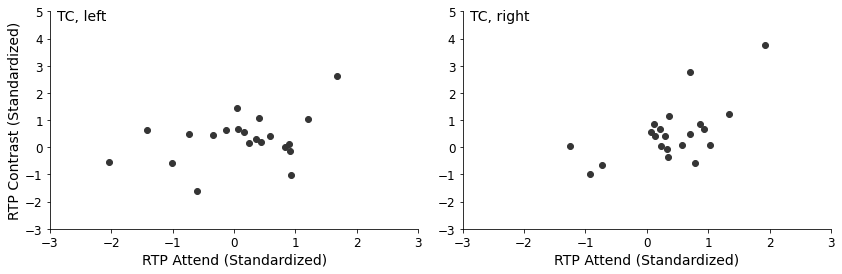

In [51]:
# Contrast growth for various regions; testing a hunch Part 1 #
# IPC: correlation for rh; IFC: correlation for both, esp lh
# TC: correlation for rh
low, high = '18', '30'
fig, axset = plt.subplots(1, 2, figsize = (14, 4))
fig.subplots_adjust(wspace=.12, hspace=.15)

plot_contrastVattend('TempAvg-lh', axset[0])
plot_contrastVattend('TempAvg-rh', axset[1])

plt.setp(axset, xlim=(-3.0, 3.0), ylim=(-3.0, 5.0));
plt.setp(axset[0], ylabel='RTP Contrast (Standardized)');
plt.setp(axset[:], xlabel='RTP Attend (Standardized)');
add_text2(axset, 'TC');

# fig_name = os.path.join(graphics_dir, 'contrast_attend_IPC.jpg')
# fig.savefig(fig_name, dpi=500)

In [55]:
# Define a plotting function #
def plot_attendignore(col_partial, ax=None, color = '#353535', subject=None):
    '''Uses global dataframe 'df'.'''
    if subject:
        subject_list = [subject]
    else:
        subject_list = df.index
    for subject in subject_list:
#         x = df.loc[subject, high] - df.loc[subject, low]
        y1 = df.loc[subject, 'ignore_' + col_partial]
        y2 = df.loc[subject, 'attend_' + col_partial]
        ax.plot(y2, y2, marker='o', color=color, fillstyle='full')
        ax.plot(y2, y1, marker='o', color=color, fillstyle='full',
                markerfacecolor='white')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

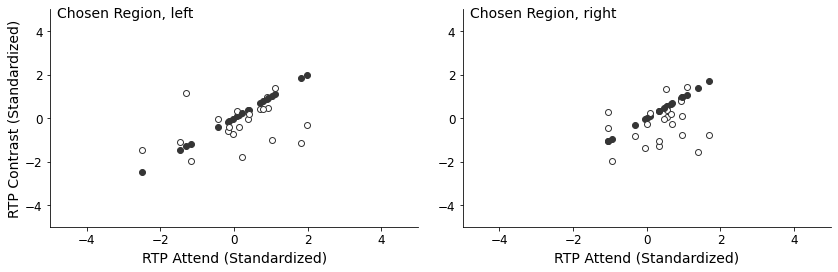

In [59]:
# Contrast growth for various regions; testing a hunch Part 2 #
# No apparent contrast versus attend RTP magnitude trends. Pat's idea
# that ignore and attend anti-correlate isn't supported here.
low, high = '18', '30'
fig, axset = plt.subplots(1, 2, figsize = (14, 4))
fig.subplots_adjust(wspace=.12, hspace=.15)

plot_attendignore('ParsAvg-lh', axset[0])
plot_attendignore('ParsAvg-rh', axset[1])

plt.setp(axset, xlim=(-5.0, 5.0), ylim=(-5.0, 5.0));
plt.setp(axset[0], ylabel='RTP Contrast (Standardized)');
plt.setp(axset[:], xlabel='RTP Attend (Standardized)');
add_text2(axset, 'Chosen Region');

# fig_name = os.path.join(graphics_dir, 'contrast_attend_IPC.jpg')
# fig.savefig(fig_name, dpi=500)

## \*\*FIG\*\* Plot labels on an inflated brain map

In [121]:
# Read in anatomical labels #
# On Thicke, make sure the data drive has been activated.
use_parc = 'aparc'
source_subject = '14mo_surr'

parc_exists = os.path.isfile(os.path.join(anatomy_dir, source_subject, 'label', f'lh.{use_parc}.annot'))
print(parc_exists)  # check for the existence of the chosen Freesurfer parcellation set

anat_labels = mne.read_labels_from_annot(source_subject, use_parc, subjects_dir=anatomy_dir)

True
Reading labels from parcellation...
   read 34 labels from /home/sbierer/Data/MEG/anatomy/14mo_surr/label/lh.aparc.annot
   read 34 labels from /home/sbierer/Data/MEG/anatomy/14mo_surr/label/rh.aparc.annot


In [122]:
# Import morphed source space #
morph_subject = '14mo_surr'
src_name = os.path.join(anatomy_dir, morph_subject,
            'bem', morph_subject + '-oct-6-src.fif')
src_morph = mne.read_source_spaces(src_name)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read


In [123]:
# Define some plotting parameters #
# No longer including entorhinal (orange).
labels_to_plot = ['parsopercularis', 'parsorbitalis', 'parstriangularis',
                  'inferiorparietal',
                  'superiortemporal', 'middletemporal', 'temporalpole']  # 'transversetemporal', 'bankssts'

label_colors = ['#008000', '#008020', '#208000',             # greens
                '#A52A2A',                                   # red
                '#0000FF', '#0000CC', '#4444FF']             # blues   '#000099'   3d3dff

In [124]:
# Define some plotting parameters #
# No longer including entorhinal (orange).
labels_to_plot = ['parsopercularis', 'parsorbitalis', 'parstriangularis',
                  'inferiorparietal',
                  'superiortemporal']

label_colors = ['#008000', '#008020', '#208000',             # greens
                '#A52A2A',                                   # red
                '#0000FF']    

In [125]:
# Show the labels of interest and optionally save #
# Getting a VTK / numpy conflict as of 2023-June. Skipping this for now.
kwargs = dict(surf='inflated', hemi='split', views='lateral',
              subjects_dir=anatomy_dir, size=(1600, 800))
brain = mne.viz.Brain(morph_subject, figure=99, **kwargs)

for lbl_base, lbl_color in zip(labels_to_plot, label_colors):
    for hemi in ('-lh', '-rh'):
        label = [lbl for lbl in anat_labels if lbl.name==lbl_base + hemi][0]
        brain.add_label(label, color=lbl_color)

brain.add_annotation(use_parc, color='grey')

In [35]:
# Save the figure #
# PNG format looks much better than JPG! Note that the entorhinal is hidden on the medial side.
fig_name = os.path.join(graphics_dir, 'roi_labelmap_lateral.png')
brain.save_image(fig_name)

## Plot residuals from various models

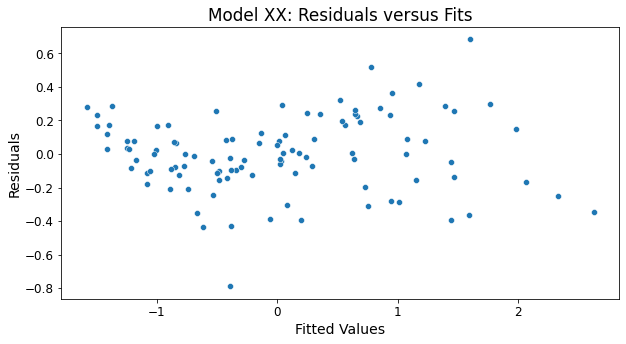

In [190]:
# Check for homoskedasticity #
# Not bad. Model 5 is obviously lower scatter.
mdf = mdf5_lharhiMIX    # mdf2_lha, mdf3_rha, mdf5_lharhiMIX

fig = plt.figure(figsize = (10, 5))
ax = sns.scatterplot(y = mdf.resid, x = mdf.fittedvalues)

ax.set_title("Model XX: Residuals versus Fits")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals");

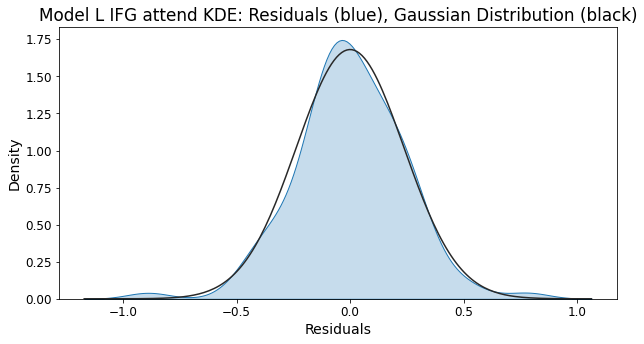

In [241]:
# Look at residuals of one of the better models #
fig = plt.figure(figsize = (10, 5))
ax = sns.distplot(mdf.resid, hist=False, kde_kws={"shade" : True, "lw": 1}, fit=stats.norm)

ax.set_title("Model L IFG attend KDE: Residuals (blue), Gaussian Distribution (black)")
ax.set_xlabel("Residuals");

In [189]:
# Statistics for normality #
# The assumption of normality is violated for each model at .05 level.
# Orig time-transform: mdf2_lha=.00087, mdf3_rha=.0035.
for mdf in (mdf2_lha, mdf3_rha, mdf5_lharhiMIX):
    norm_sw = stats.shapiro(mdf.resid)
    print(norm_sw)

ShapiroResult(statistic=0.9802371263504028, pvalue=0.11903943121433258)
ShapiroResult(statistic=0.9845940470695496, pvalue=0.2657117247581482)
ShapiroResult(statistic=0.9847633242607117, pvalue=0.27383309602737427)


In [191]:
df_roidb.head(2)

,18,21,24,27,30,attend_ParsTri-lh,attend_ParsTri-rh,ignore_ParsTri-lh,ignore_ParsTri-rh,attend_ParsOper-lh,...,ignore_PoleTemp-lh,ignore_PoleTemp-rh,attend_ParsAvg-lh,attend_ParsAvg-rh,ignore_ParsAvg-lh,ignore_ParsAvg-rh,attend_TempAvg-lh,attend_TempAvg-rh,ignore_TempAvg-lh,ignore_TempAvg-rh
subject,,,,,,,,,,,,,,,,,,,,,
f2f_009,-1.20258,-0.84281,-0.30567,0.59538,0.99481,-3.62808,-2.66349,-4.12667,-3.58249,-2.97353,...,-3.96081,-3.39748,-3.53613,-2.73493,-4.05892,-3.57253,-3.50609,-2.74679,-4.07554,-3.39621
f2f_010,-1.33074,-1.29473,-0.92429,-0.41760,0.18365,-6.19275,-4.67896,-5.15764,-3.34809,-6.56592,...,-4.91019,-3.82532,-6.11787,-4.71196,-5.10874,-3.38404,-5.68363,-4.57635,-5.13489,-3.59118


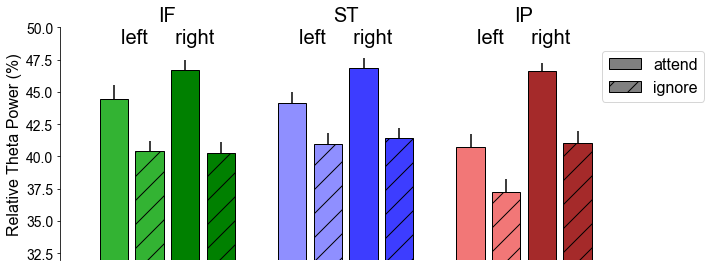

In [175]:
# Grouped bar chart w/ averaged ROIs, highlighting attend vs ignore in left and right hemispheres #
# Note that the standard error bars, since they are expressed in linear units, are
# calculated according to the following link:
#   https://stats.stackexchange.com/questions/123514/calculating-standard-error-after-a-log-transform
# MAKE SURE TO UNCOMMENT 'SAVEFIG()' LINE TO SAVE THE FIGURE!
roi_base = {'ParsAvg':'IF', 'TempAvg':'ST', 'InfPar':'IP'}
lh_colors = ['#33B333', '#6666FF', '#F27777']  # rh match ROI map or darker, lh are lighter
rh_colors = ['#008000', '#0000B3', '#A52A2A']  # shading via https://www.hexcolortool.com/

width, offset = 0.16, 0.20

fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.bar(-5, 40, width, edgecolor='k', color='grey');  # fake data for legend
ax.bar(-5, 40, width, edgecolor='k', color='grey', hatch = '/');

div = np.sqrt(len(df_roidb) - 1)
for xx, roi in enumerate(roi_base):
    avg_a = df_roidb['attend_' + roi + '-lh'].mean()/10 + 2
    ste_a = df_roidb['attend_' + roi + '-lh'].std()/(10*div)  # see note in header
    ste_a = (10**avg_a) * ste_a
    avg_i = df_roidb['ignore_' + roi + '-lh'].mean()/10 + 2
    ste_i = df_roidb['ignore_' + roi + '-lh'].std()/(10*div)
    ste_i = (10**avg_i) * ste_i
    ax.bar(xx - 1.5*offset, 10**avg_a, width, edgecolor='k', yerr=np.array([[0],[ste_a]]),
           color=lh_colors[xx]);
    ax.bar(xx - .5*offset, 10**avg_i, width, edgecolor='k', yerr=np.array([[0],[ste_i]]),
           color=lh_colors[xx], hatch = '/');
    
    avg_a = df_roidb['attend_' + roi + '-rh'].mean()/10 + 2
    ste_a = df_roidb['attend_' + roi + '-rh'].std()/(10*div)
    ste_a = (10**avg_a) * ste_a
    avg_i = df_roidb['ignore_' + roi + '-rh'].mean()/10 + 2
    ste_i = df_roidb['ignore_' + roi + '-rh'].std()/(10*div)
    ste_i = (10**avg_i) * ste_i
    ax.bar(xx + .5*offset, 10**avg_a, width, edgecolor='k', yerr=np.array([[0],[ste_a]]),
           color=rh_colors[xx]);
    ax.bar(xx + 1.5*offset, 10**avg_i, width, edgecolor='k', yerr=np.array([[0],[ste_i]]),
           color=rh_colors[xx], hatch = '/');

ax.set_xlim((-.6, 2.5))

ax.set_xticks(np.arange(len(roi_base)))
ax.tick_params('x', length=0, pad=-20)
ax.set_xticklabels([(roi_base[roi] + '\nleft     right') for roi in roi_base], fontsize=20)
ax.set_ylim((32, 50))
ax.set_ylabel('Relative Theta Power (%)', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.tick_top()

leg = ax.legend(['attend', 'ignore'], loc=(0.98, 0.68), prop={'size': 16})

fig.tight_layout();
plt.show();

fig_name = os.path.join(graphics_dir, 'barchart_ROIs_pct.jpg')
fig.savefig(fig_name, dpi=500)

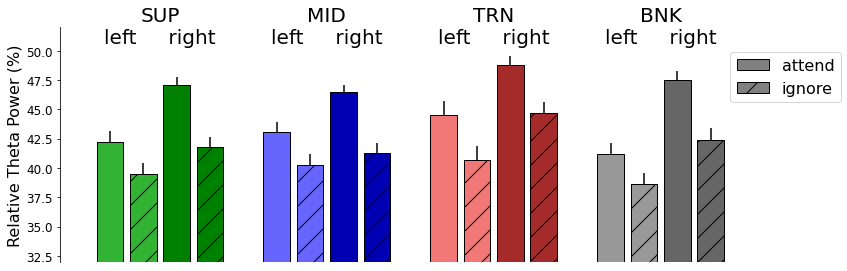

In [339]:
# TEST ONLY #
roi_base = {'SupTemp':'SUP', 'MidTemp':'MID', 'TransTemp':'TRN', 'BanksTemp':'BNK'}
lh_colors = ['#33B333', '#6666FF', '#F27777', '#999999']
rh_colors = ['#008000', '#0000B3', '#A52A2A', '#666666']
width, offset = 0.16, 0.20

fig, ax = plt.subplots(1, 1, figsize = (12, 4))
ax.bar(-5, 40, width, edgecolor='k', color='grey');  # fake data for legend
ax.bar(-5, 40, width, edgecolor='k', color='grey', hatch = '/');

div = np.sqrt(len(df_roidb) - 1)
for xx, roi in enumerate(roi_base):
    avg_a = df_roidb['attend_' + roi + '-lh'].mean()/10 + 2
    ste_a = df_roidb['attend_' + roi + '-lh'].std()/(10*div)  # see note in header
    ste_a = (10**avg_a) * ste_a
    avg_i = df_roidb['ignore_' + roi + '-lh'].mean()/10 + 2
    ste_i = df_roidb['ignore_' + roi + '-lh'].std()/(10*div)
    ste_i = (10**avg_i) * ste_i
    ax.bar(xx - 1.5*offset, 10**avg_a, width, edgecolor='k', yerr=np.array([[0],[ste_a]]),
           color=lh_colors[xx]);
    ax.bar(xx - .5*offset, 10**avg_i, width, edgecolor='k', yerr=np.array([[0],[ste_i]]),
           color=lh_colors[xx], hatch = '/');
    
    avg_a = df_roidb['attend_' + roi + '-rh'].mean()/10 + 2
    ste_a = df_roidb['attend_' + roi + '-rh'].std()/(10*div)
    ste_a = (10**avg_a) * ste_a
    avg_i = df_roidb['ignore_' + roi + '-rh'].mean()/10 + 2
    ste_i = df_roidb['ignore_' + roi + '-rh'].std()/(10*div)
    ste_i = (10**avg_i) * ste_i
    ax.bar(xx + .5*offset, 10**avg_a, width, edgecolor='k', yerr=np.array([[0],[ste_a]]),
           color=rh_colors[xx]);
    ax.bar(xx + 1.5*offset, 10**avg_i, width, edgecolor='k', yerr=np.array([[0],[ste_i]]),
           color=rh_colors[xx], hatch = '/');

ax.set_xlim((-.6, 3.5))

ax.set_xticks(np.arange(len(roi_base)))
ax.tick_params('x', length=0, pad=-20)
ax.set_xticklabels([(roi_base[roi] + '\nleft     right') for roi in roi_base], fontsize=20)
ax.set_ylim((32, 52))
ax.set_ylabel('Relative Theta Power (%)', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.tick_top()

leg = ax.legend(['attend', 'ignore'], loc=(0.98, 0.68), prop={'size': 16})

fig.tight_layout();
plt.show();

## \*\*FIG\*\* Plot average attend and ignore levels as a bar graph - linear validation
Like the figure in the previous section, except here the linearization was done BEFORE averaging (because statistics from that per-subject / per-band ROI data are being calculated for the F2F paper).  

The two figures, here and above, are very comparable in both mean and standard error.

In [58]:
df_roilin.head(2)

,18,21,24,27,30,attend_ParsTri-lh,attend_ParsTri-rh,ignore_ParsTri-lh,ignore_ParsTri-rh,attend_ParsOper-lh,attend_ParsOper-rh,ignore_ParsOper-lh,ignore_ParsOper-rh,attend_ParsOrb-lh,attend_ParsOrb-rh,ignore_ParsOrb-lh,ignore_ParsOrb-rh,attend_InfPar-lh,attend_InfPar-rh,ignore_InfPar-lh,ignore_InfPar-rh,attend_SupTemp-lh,attend_SupTemp-rh,ignore_SupTemp-lh,ignore_SupTemp-rh,attend_MidTemp-lh,attend_MidTemp-rh,ignore_MidTemp-lh,ignore_MidTemp-rh,attend_TransTemp-lh,attend_TransTemp-rh,ignore_TransTemp-lh,ignore_TransTemp-rh,attend_BanksTemp-lh,attend_BanksTemp-rh,ignore_BanksTemp-lh,ignore_BanksTemp-rh,attend_PoleTemp-lh,attend_PoleTemp-rh,ignore_PoleTemp-lh,ignore_PoleTemp-rh,attend_ParsAvg-lh,attend_ParsAvg-rh,ignore_ParsAvg-lh,ignore_ParsAvg-rh,attend_TempAvg-lh,attend_TempAvg-rh,ignore_TempAvg-lh,ignore_TempAvg-rh
subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f2f_009,-1.20258,-0.84281,-0.30567,0.59538,0.99481,43.37030,54.15661,38.66636,43.82789,50.42518,55.72306,45.02516,45.39004,39.74855,50.09948,34.79650,42.61166,49.01462,52.77906,39.15818,42.28220,46.55966,54.58409,39.36209,46.39820,43.76894,52.63263,37.87391,45.12160,48.95679,58.25663,43.45308,50.26728,49.51043,57.25103,39.33015,47.09860,43.55096,52.19667,40.17161,45.73534,44.51468,53.32638,39.49601,43.94320,44.62652,53.13780,39.13587,45.75171
f2f_010,-1.33074,-1.29473,-0.92429,-0.41760,0.18365,24.02841,34.04899,30.49554,46.25840,22.04996,31.77046,30.93266,44.89385,27.57434,35.66840,31.09742,46.49559,18.62267,35.12168,21.22889,42.01879,27.14334,38.64925,29.36454,46.34781,26.76163,35.57484,30.38990,43.56625,22.44533,39.62574,27.66984,47.38545,22.70526,35.22449,23.86779,42.59497,27.14778,30.81836,32.28354,41.44458,24.55090,33.82928,30.84188,45.88262,27.01759,35.01415,30.67933,43.78622


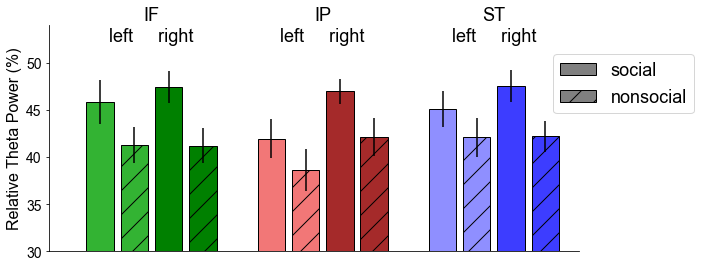

In [62]:
# Make a grouped bar chart, to highlight attend vs ignore in left and right hemispheres #
# The stds are calculated without transformation, unlike above. This may not be strictly valid,
# but it's being done this way for comparison.
# MAKE SURE TO UNCOMMENT 'SAVEFIG()' LINE TO SAVE THE FIGURE!
roi_base = {'ParsAvg':'IF', 'InfPar':'IP', 'TempAvg':'ST'}
# lh_colors = ['#33B333', '#6666FF', '#F27777']  # rh match ROI map or darker, lh are lighter
# rh_colors = ['#008000', '#0000B3', '#A52A2A']  # shading via https://www.hexcolortool.com/
lh_colors = ['#33B333', '#F27777', '#8f8fff']  # rh match ROI map or darker, lh are lighter
rh_colors = ['#008000', '#A52A2A', '#3d3dff']  # shading via https://www.hexcolortool.com/
width, offset = 0.16, 0.20

fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.bar(-5, 40, width, edgecolor='k', color='grey');  # fake data for legend
ax.bar(-5, 40, width, edgecolor='k', color='grey', hatch = '/');

div = np.sqrt(len(df_roilin) - 1)
for xx, roi in enumerate(roi_base):
    avg_a = df_roilin['attend_' + roi + '-lh'].mean()
    ste_a = df_roilin['attend_' + roi + '-lh'].std()  # see note in header
    ste_a /= np.sqrt(len(df_roilin))
    avg_i = df_roilin['ignore_' + roi + '-lh'].mean()
    ste_i = df_roilin['ignore_' + roi + '-lh'].std()
    ste_i /= np.sqrt(len(df_roilin))
    ax.bar(xx - 1.5*offset, avg_a, width, edgecolor='k', yerr=np.array([ste_a]),
           color=lh_colors[xx]);
    ax.bar(xx - .5*offset, avg_i, width, edgecolor='k', yerr=np.array([ste_i]),
           color=lh_colors[xx], hatch = '/');
    
    avg_a = df_roilin['attend_' + roi + '-rh'].mean()
    ste_a = df_roilin['attend_' + roi + '-rh'].std()
    ste_a /= np.sqrt(len(df_roilin))
    avg_i = df_roilin['ignore_' + roi + '-rh'].mean()
    ste_i = df_roilin['ignore_' + roi + '-rh'].std()
    ste_i /= np.sqrt(len(df_roilin))
    ax.bar(xx + .5*offset, avg_a, width, edgecolor='k', yerr=np.array([ste_a]),
           color=rh_colors[xx]);
    ax.bar(xx + 1.5*offset, avg_i, width, edgecolor='k', yerr=np.array([ste_i]),
           color=rh_colors[xx], hatch = '/');

ax.set_xlim((-.6, 2.5))

ax.set_xticks(np.arange(len(roi_base)))
ax.tick_params('x', length=0, pad=-20)
ax.set_xticklabels([(roi_base[roi] + '\nleft     right') for roi in roi_base], fontsize=18)
ax.set_ylim((30, 54))
ax.set_ylabel('Relative Theta Power (%)', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.xaxis.tick_top()

leg = ax.legend(['social', 'nonsocial'], loc=(0.95, 0.61), prop={'size': 18})

fig.tight_layout();
plt.show();

fig_name = os.path.join(graphics_dir, 'barchart_linearROIs_pct.jpg')
fig.savefig(fig_name, dpi=500)

## End